# --------------- Parte 1 ---------------
## Introducción

Al operador de telecomunicaciones **Interconnect** le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de **Interconnect** ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

**Servicios de Interconnect**

**Interconnect** proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

**Descripción de los datos**

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

## Análisis

Conforme a la información proporcionada por **Interconnect** lo primero que debemos hacer es analizar la información contenida en cada uno de los archivos `csv` para entender de que forma se trabajará posteriormente para poder obtener predicciones lo más precisas posibles, con alta escalabidad y evitando a toda costa el sobreentrenamiento.

Comenzaremos analizando `contract.csv`.

In [1]:
# Importando librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from scipy import stats as st
from scipy.stats import levene
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [2]:
# Importando y visualizando información de "contract.csv"
df_contract = pd.read_csv("datasets/final_provider/contract.csv")
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [3]:
# Visualizando datos de "df_contract"
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


De acuerdo con la información, podemos observar que no tenemos registros faltantes en ninguna de las filas de `df_contract`, por lo que analizaremos la información que nos proporciona columna a columna.

- `customerID`: Es información alfanumérica que incluye símbolos, más especificaménte el guión ("-").
- `BeginDate`: Esta columna nos porporciona la fecha exacta en la que el cliente inicio su contrato con empresa. Esta columna debe ser del tipo `datetime`.
- `EndDate`: En caso de aplicar, nos indica la fecha en la que el cliente finalizo el contrato con la empresa. Esta columna debe ser del tipo `datetime`.
- `Type`: El tipo de pago que se realiza que debe contener unicaménte 3 opciones `mensual`, `anual` y `bienal`.
- `PaperlessBilling`: Si la facturación es eléctronica o física.
- `PaymentMethod`: La forma de pago de preferencia del cliente.
- `MonthlyCharges`: Cargos mensuales.
- `TotalCharges`: Cargos totales que aparentemente es la suma de los cargos realizados desde el inicio del contrato hasta el momento de finalización o la fecha actual según sea el caso. Esta columan debe ser del tipo `float`.

De forma general podemos resaltar que por buenas prácticas, hay columnas que de inicio deben ser cambiadas de formato al correspondiente y el nombre descriptivo de cada columna debe ser `snake case`. Además también, podemos resaltar hasta este punto algunas preguntas que son:

1. El cargo mensual es un monto fijo?
2. Realmente el total de cargos es la suma del plazo contratado hasta el momento? Si no es el caso, qué otros cargos se estan considerando?

**Nota**: Si bien aparentemente hasta este momento tenemos información irrelevante como es el caso de `PaperlessBilling` no podemos considerar realizar una pregunta o incluso descartar dicha columna pues aun tenemos pendiente ver si hay alguna relación con el resto de archivos `csv`.

Continuaresmos con `personal.csv`.

In [4]:
# Importando y visualizando información de "personal.csv"
df_personal = pd.read_csv("datasets/final_provider/personal.csv")
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [5]:
# Visualizando datos de "df_personal"
df_personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


Para el caso de este `df`, tenemos la misma situación respecto al nombre de las columnas que a continuación describiremos:

- `gender`: Nos describe el género del titual del contrato con la empresa.
- `SeniorCitizen`: Describe si se trata de un adulto mayor o no por lo que se entendería que aquellos que tienen un valor de `0` no son personas mayores mientras que `1` indica que si lo son.
- `Partner`: Nos indica si el titual del contrato tiene pareja que aparentemente puede ser una columna que no aporta suficiente información al análisis.
- `Dependents`: Nos indica si el titular tiene dependientes de el mismo y es el mismo caso que la columna anteriormente descrita, puede considerarse información no útil para el análisis.

Basicaménte pareciera que esta tabla nos proporciona un estudio socio económico muy breve de los clientes.

Continuaremos explorando la siguiente tabla que es `internet.csv`.

In [6]:
# Importando y visualizando información de "internet.csv"
df_internet = pd.read_csv("datasets/final_provider/internet.csv")
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [7]:
# Visualizando datos de "df_internet"
df_internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


Esta tabla nos indica quienes de los clientes tienen contratado el servicio a través de internet y que servicios adicionales estan dados de alta. A continuación describiremos las columnas.

- `InternetService`: Tecnología utilizada para proporcionar el servicio.
- `OnlineSecurity`: Bloqueador de sitios web maliciosos.
- `OnlineBackup`: Almacenamiento de archivos en la nube y backup de datos.
- `DeviceProtection`: Software antivirus.
- `TechSupport`: Soporte técnico.
- `StreamingTV`: Streaming de TV.
- `StreamingMovies`: Streaming de peliculas.

Tenemos la misma situación respecto a los nombres descriptivos de las columnas añadiendo que algunas de las columnas pueden ser del tipo `bool` que es el caso desde `OnlineSecurity` y hacia abajo de la anterior lista descriptiva presentada.

Por último, trabajaremos con el archivo `phone.csv`.

In [8]:
# Importando y visualizando información de "phone.csv"
df_phone = pd.read_csv("datasets/final_provider/phone.csv")
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [9]:
# Visualizando datos de "df_phone"
df_phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


Respecto a `df_phone`, podemos observar que solo nos proporciona una columna de información que nos indica si el usuario cuenta con el uso de lineas múltiples.

A partir de este punto, podemos comenzar con un análisis más profundo de cada una de las tablas con la intención de descubrir relaciones y aplicar el preprocesamiento que sea requerido para poder conjuntar los datos de relevancia y dar pie e los modelos predictivos.

# Análisis exploratorio

Comenzaremos con el formateo de los nombres de las columnas de cada tabla.

In [10]:
# Aplicando "snake_case" a los nombres de las columnas de "df_contract"
df_contract.rename(columns={'customerID':'customer_id','BeginDate':'begin_date','EndDate':'end_date',
                            'Type':'type','PaperlessBilling':'paperless_billing','PaymentMethod':'payment_method',
                            'MonthlyCharges':'monthly_charges','TotalCharges':'total_charges'},inplace=True)
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [11]:
# Aplicando "snake_case" a los nombres de las columnas de "df_personal"
df_personal.rename(columns={'customerID':'customer_id','SeniorCitizen':'senior_citizen',
                            'Partner':'parner','Dependents':'dependents'},inplace=True)
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   parner          7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [12]:
# Aplicando "snake_case" a los nombres de las columnas de "df_internet"
df_internet.rename(columns={'customerID':'customer_id','InternetService':'internet_service',
                            'OnlineSecurity':'online_security','OnlineBackup':'online_backup',
                            'DeviceProtection':'device_protection','TechSupport':'tech_support',
                            'StreamingTV':'streaming_tv','StreamingMovies':'streaming_movies'},inplace=True)
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [13]:
# Aplicando "snake_case" a los nombres de las columnas de "df_phone"
df_phone.rename(columns={'customerID':'customer_id','MultipleLines':'multiple_lines'},inplace=True)
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Una vez hemos seguido las buenas prácticas respecto al nombre descriptivo de cada columna, comenzaremos con el preprocesamiento de `df_contract`.

## Ajuste y exploración de "df_contract"

Ya que las filas de esta tabla (y en general de todas) no esta incompleta, comenzaremos verificando duplicidad de registros, así también exploraremos cada columna con la intención de verificar que tipo de dato es con el que cuenta actualmente y si estos deben ser cambiados a otro tipo de dato.

In [14]:
# Verificando duplicidad de registros
df_contract.duplicated().sum()

0

In [15]:
# Implimiento primeros 5 registros
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Como podemos verificar en este punto, tanto la columna `begin_date` como `end_date` cuentan con un tipo de dato incorrecto, ademas que, el formato que manejan no esta homologado pues en uno toma en cuenta las horas, por lo que para llevar un orden a lo largo del análisis de esta tabla, procederemos a realizar las correcciones pertinentes para estas dos columnas resaltando lo siguiente:

- `begin_date`: Es una columna que podrá ser procesada de forma directa pues todos los registros contenidos se tratan de fechas.
- `end_date`: Es una columna que debe ser procesada con cuidado pues no todos los registros son fechas que de ser cambiadas provocaría un análisis erroneo.

Con la intención de eficientar este proceso, crearemos una función que permita hacer el cambio de tipo de dato contemplando aquellos casos que no se trate de una fecha, para esto, primero verificaremos cuales son aquellos campos normalizados que indican que dicho contrato no ha finalizado aun en la columna `end_date`.

In [16]:
# Validando "end_date"
df_contract['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

De acuerdo con la información, tenemos un caso interesante pues la gran mayoria aun cuenta con un contrato vigente sin embargo aquellos clientes que decidierón finalizar el mismo solo lo han hecho en 3 fechas en específico que son:

- `2019-10-01` con 458 finalizaciones de contrato.
- `2019-11-01` con 485 finalizaciones de contrato.
- `2019-12-01` con 466 finalizaciones de contrato.
- `2020-01-01` con 460 finalizaciones de contrato.

Esta sección es interesante pues **Interconnect** especifíca lo siguiente:

    **La información del contrato es válida a partir del 1 de febrero de 2020.**
    
Lo cuál nos lleva a la primer pregunta **¿Todos aquellos contratos que son anteriores al 1 de febrero de 2020 deben ser omitidos de este modelo?**.

Sin embargo para poder procesar esta sección es importante que hagamos el cambio de tipo de dato para estas columnas por lo que continuaremos con la creación de la función que contemple aquellos casos en que los registros no puedan ser modificados.

In [17]:
# Creando "change_to_datetime"
def change_to_datetime(data):
    if data == 'No':
        return data
    else:
        return pd.to_datetime(data)

In [18]:
# Aplicando "change_to_datetime" a las columnas "begin_date" y "end_date"
df_contract['begin_date'] = df_contract['begin_date'].apply(change_to_datetime)
df_contract['end_date'] = df_contract['end_date'].apply(change_to_datetime)
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


En este punto cabe resaltar que aunque parece que para la columna `end_date` no hubó algún cambio, estos si fueron aplicados sin embargo como se tienen dos tipos de datos en esta columna por aquellas filas que tienen como dato `No` se ajusta de forma general a un tipo de dato `str`.

Continuaremos trabajando con la siguiente columna que es `type` la cuál nos indica la temporalidad de pago del cliente por su servicio lo que nos indica que es una columna con valores categóricos.

In [19]:
# Validando "type"
df_contract['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

Efectivamente, esta colmna contiene datos categóricos que deben ser procesados haciendo uso de `OneHotEncoder` y el motivo de usar este encoder y no `LabelEncoder` es porque son datos aislados, es decir, uno no tiene relación de ningún tipo con el restante. Sin embargo, este procedimiento lo realizaremos al final pues primero debemos descubrir relaciones, datos atípicos, etc.

Continuaremos trabajando con `paperless_billing`.

In [20]:
# Validando "paperless_billing"
df_contract['paperless_billing'].value_counts()

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

Nuevamente contamos con una columna categórica. Trabajaremos con `payment_method`.

In [21]:
# Validando "payment_method"
df_contract['payment_method'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

Por último tenemos la columna `total_charges` que podemos ver desde el recuadro de información que se trata de un cambio de tipo de dato pues deben ser valores numéricos mas no alfanuméricos por lo que procederemos con el cambio de tipo de dato para posteriormente comenzar con los análisis requeridos.

In [22]:
# Validando "total_charges"
df_contract['total_charges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: total_charges, Length: 6531, dtype: int64

Como podemos observar, hay `11` registros que no nos permitirían realizar el cambio del tipo de dato al correcto por lo que procederemos a cambiar dicho valor por `0` para que no pierda significado dentro del contexto del valor original.

In [23]:
# Aplicando corrección del tipo de dato
def cambio_datos(data,value,change):
    if data != value:
        return data
    else:
        return change
    
df_contract['total_charges'] = df_contract['total_charges'].apply(lambda x: cambio_datos(x," ",0))

In [24]:
# Cambiando el tipo de dato de "object" a "int"
df_contract = df_contract.astype({'total_charges':'float'})
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


Ya que tenemos todas las columnas con el tipo de dato correcto podemos darnos cuenta que dentro de esta tabla tenemos nuestra columna objetivo, es decir, la columna `end_date` es aquella que nos indica si el cliente continua con un contrato con la empresa o ya decidió finalizar con el mismo por lo que profundizaremos en la relación que existe entre las distintas características de `df_contract` que termien en dicho resultado.

Partiremos de explorar la relación que hay entre el tipo de periodo de pago que puede ser mensual, anual o bienal y para esto, añadiremos una nueva columna que nos ayude `contract_ends`.

In [25]:
# Creando la columna auxiliar "contract_ends"
df_contract['contract_ends'] = pd.Series(range(len(df_contract)))
df_contract['contract_ends'].loc[df_contract['end_date'] != 'No'] = 'Si'
df_contract['contract_ends'].loc[df_contract['end_date'] == 'No'] = 'No'

/var/folders/g2/6f4slx3d02g5s4th9bbb102m0000gn/T/ipykernel_51353/2482656376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contract['contract_ends'].loc[df_contract['end_date'] != 'No'] = 'Si'


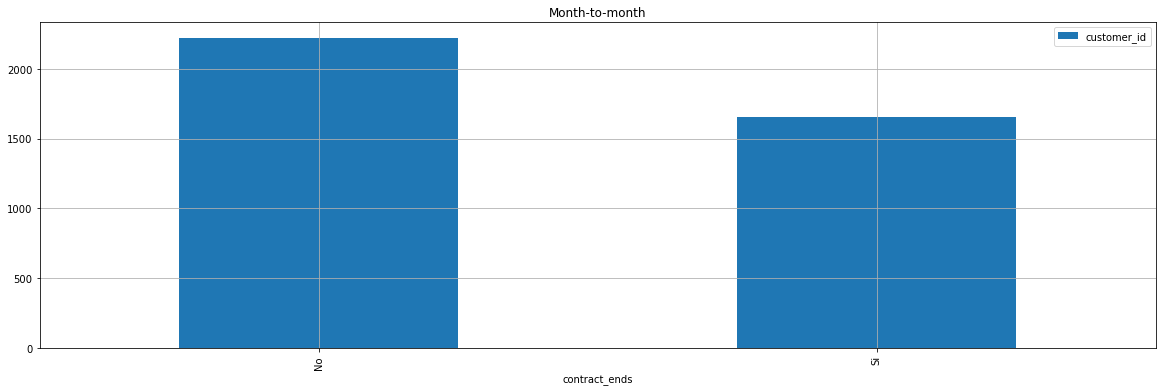

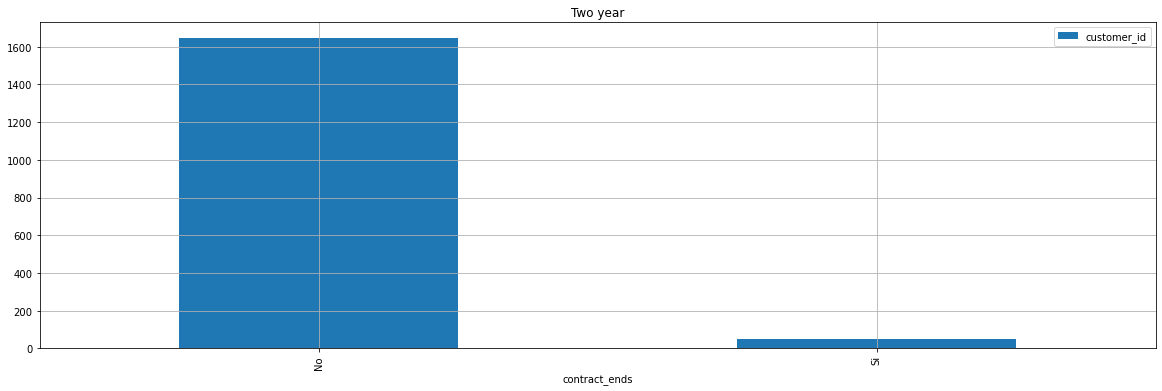

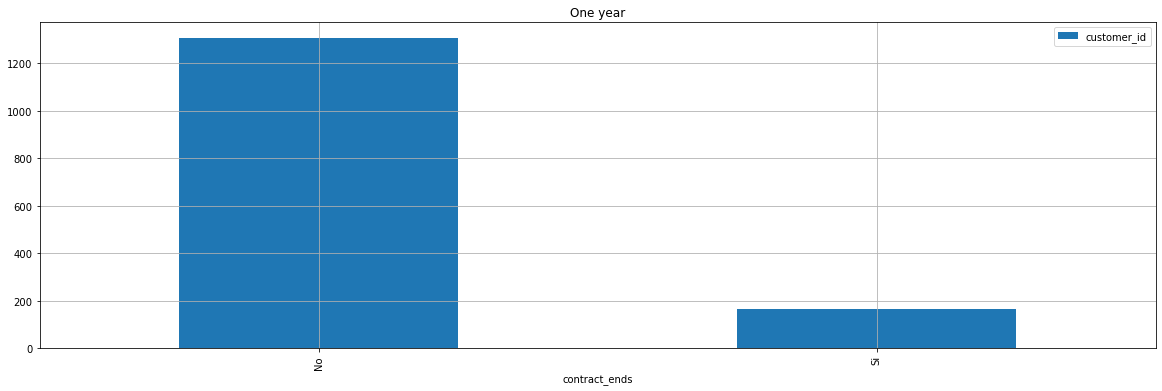

In [26]:
# Visualizando relación entre "type" y "end_date"
types = df_contract['type'].value_counts().index
for i in types:
    df_contract[df_contract['type'] == i].groupby('contract_ends').count()['customer_id'].plot(kind='bar',
                                                                 legend=True,
                                                                 figsize=(20,6),
                                                                 grid=True,title=i)
    plt.show()

Como podemos observar, si bien, los clientes prefieren el cargo por el servicio de manera mensual, también es la forma de pago que más finalizaciones de contrato ha recibido pues dejandolo en números exactos tenemos la siguiente relación:

In [27]:
# Relación de la temporalidad de pago con los contratos
df_contract.groupby(['type','contract_ends']).count()['customer_id']

type            contract_ends
Month-to-month  No               2220
                Si               1655
One year        No               1307
                Si                166
Two year        No               1647
                Si                 48
Name: customer_id, dtype: int64

Lo que podemos expresar en lo siguiente:

- `Month-to-month`: De los `3,875` el `42%` ha finalizado ya su contrato.
- `One year`: De los `1,473` el `11%` ha finalizado ya su contrato.
- `Two years`: De los `1,695` apenas el `2%` ha finalizado ya su contrato.

Esto puede deberse a muchas cosas, para empezar la temporalidad puede que implique que pocas personas han logrado concluir aquellos contratos de un año o dos por lo que debemos verificar cuál es el margen de fechas con los que se cuenta.

In [28]:
# Verificando rango del periodo de los contratos actuales
start = df_contract['begin_date'].min()
end = df_contract[df_contract['end_date'] != 'No']['end_date'].max()
print(f'El periodo de fechas va desde {start} hasta {end}.')

El periodo de fechas va desde 2013-10-01 00:00:00 hasta 2020-01-01 00:00:00.


Esto nos indica que tenemos un rango bastante amplio por lo que hay margen para finalizar aquellos contratos con pagos `anuales` o `bienales`, sin embargo, se remarca la pregunta anteriormente planteada por lo que es importante que conozcamos hasta que fecha es donde estamos contemplando puesto que hay contratos aun vigentes.

Ahora trabajaremos de la misma manera pero ahora considerando `payment_method` para ver si hay alguna relación entre los contratos finalizados y vigentes y el metodo de pago utilizado por los clientes.

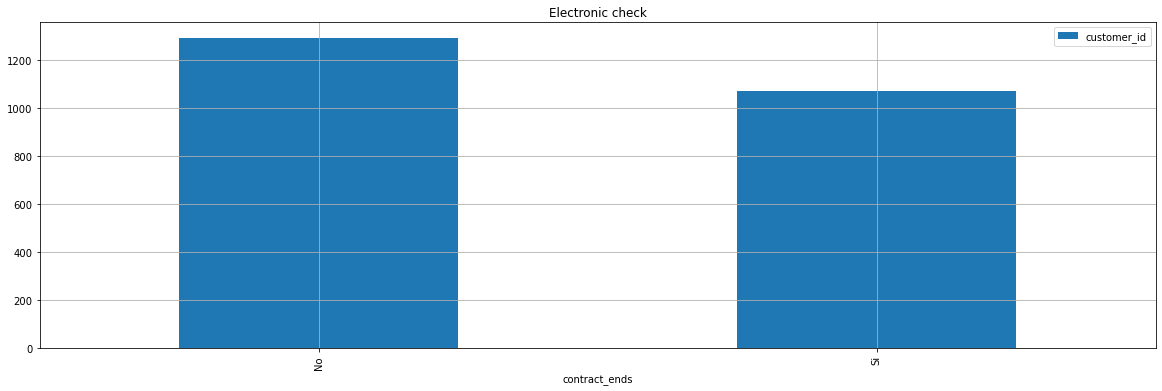

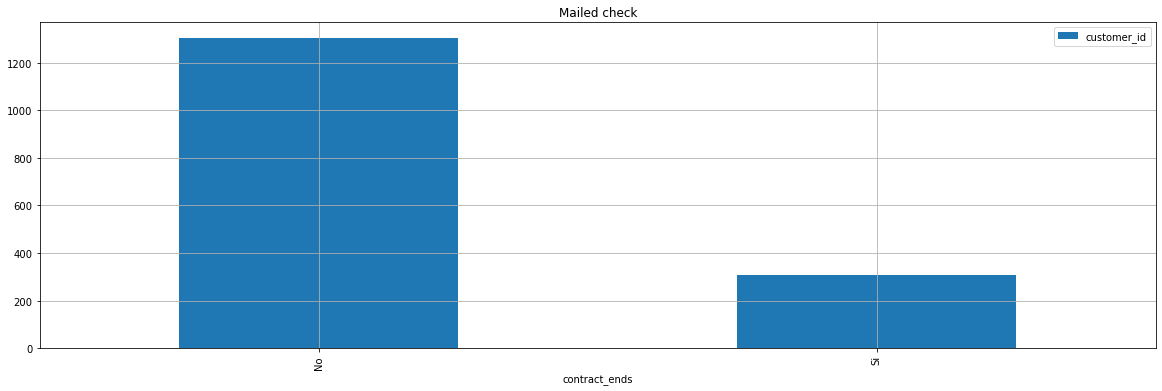

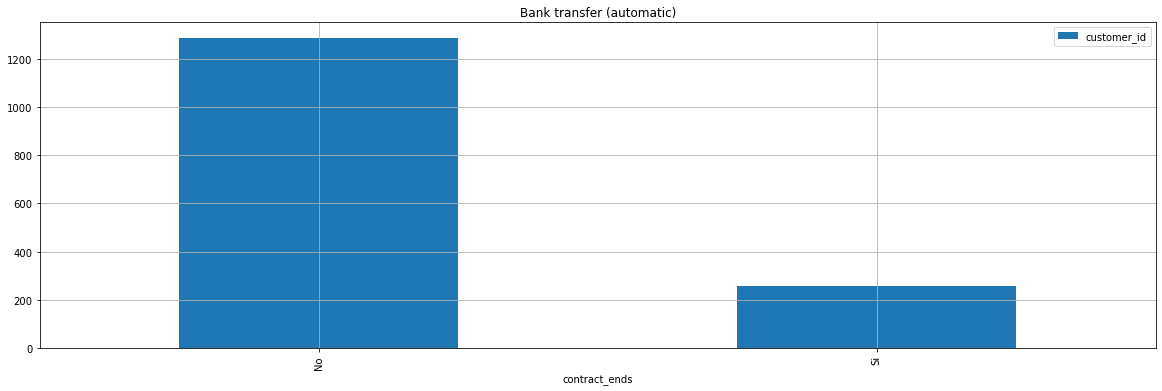

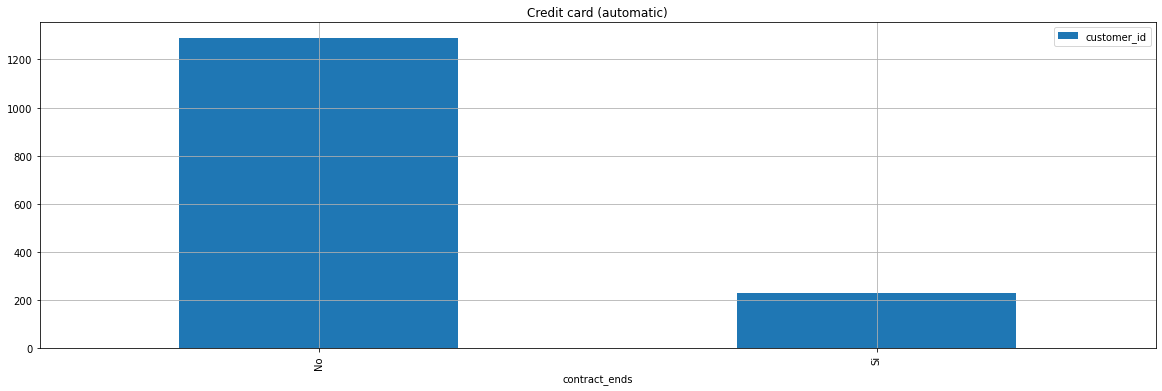

In [29]:
# Visualizando relación entre "payment_method" y "end_date"
types = df_contract['payment_method'].value_counts().index
for i in types:
    df_contract[df_contract['payment_method'] == i].groupby('contract_ends').count()['customer_id'].plot(kind='bar',
                                                                 legend=True,
                                                                 figsize=(20,6),
                                                                 grid=True,title=i)
    plt.show()

In [30]:
# Relación de metodo de pago con los contratos
df_contract.groupby(['payment_method','contract_ends']).count()['customer_id']

payment_method             contract_ends
Bank transfer (automatic)  No               1286
                           Si                258
Credit card (automatic)    No               1290
                           Si                232
Electronic check           No               1294
                           Si               1071
Mailed check               No               1304
                           Si                308
Name: customer_id, dtype: int64

Como podemos apreciar en este punto, la relación del metodo de pago de preferencia por los clientes es relativamente similar para los 4 casos. Sin embargo, aquellos clientes que utilizan el método de pago `Electronic check` tienen un porcentaje considerablemente más alto con respecto al resto lo que puede deberse posiblemente a que el método de pago presenta muchos problemas para completarse.

Ahora continuaremos analizando si existen valores atípicos en las columnas `monthly_charges` y `total_charges`.

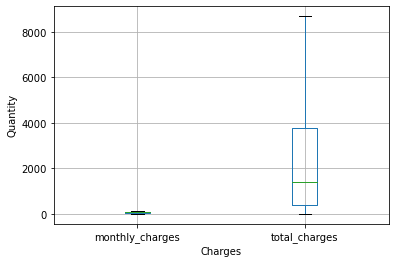

In [31]:
# Verificando valores atípicos en "monthly_charges"
df_contract[['monthly_charges','total_charges']].boxplot()
plt.xlabel('Charges')
plt.ylabel('Quantity')
plt.show()

Como podemos observar, al tratarse de un cargo mensual, vemos un `boxplot` equitativo, no se visualizan valores atípicos y la media de este se encuentraen un rango definido pero al visualizar la columna `total_charges` podríamos interpretar esto como que cuenta con valores atípicos puesto que visualizamos una media muy por debajo del 3er cuartil y aun más del valor máximo que se encuentra en esta columna. Sin embargo esto puede no ser del todo cierto pues recordemos que el rango de fechas abarca desde el año `2013` al `2020` y puede que exitan clientes que iniciarón en el `2013` y aun cuenten con un contrato vigente.

In [32]:
# Validando valores atípicos
df_contract[df_contract['total_charges'] > 8000].sort_values(by='total_charges',
                                                             ascending=False)[['begin_date','end_date']]

,begin_date,end_date
4610,2013-10-01,2019-10-01 00:00:00
4586,2014-02-01,No
6768,2014-02-01,No
5347,2014-02-01,No
2187,2014-03-01,No
...,...,...
4885,2014-02-01,No
5537,2014-03-01,No
1746,2014-02-01,No
3247,2014-02-01,No


Como podemos observar hay un registro que tuvo un contrato por 6 años lo que indica que su factura es de las más altas de `df_contract`, para asegurarnos de esto nos enfocaremos en este registro por ahora.

In [33]:
# Encontrando registro con el "atípico"
df_contract[df_contract['total_charges'] == df_contract['total_charges'].max()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_ends
4610,2889-FPWRM,2013-10-01,2019-10-01 00:00:00,One year,Yes,Bank transfer (automatic),117.8,8684.8,Si


In [34]:
# Validando cargos mensuales y anuales
monthly = float(df_contract[df_contract['customer_id'] == '2889-FPWRM']['monthly_charges'])
contract_time = 6
anual_charge = monthly * 12
total_charge = anual_charge * contract_time

print(f'El cliente con id "2889-FPWRM" tiene un cargo mensual de "{monthly}", por lo que anualmente su factura es de "{anual_charge}" y por el periodo total es de "{total_charge}".')

El cliente con id "2889-FPWRM" tiene un cargo mensual de "117.8", por lo que anualmente su factura es de "1413.6" y por el periodo total es de "8481.599999999999".


Si extraemos la información de este usuario tenemos una pequeña diferencia entre el cargo total por contrato y el calculado de acuerdo al cargo mensual que genera dicho contrato por lo que podemos asumir que los servicios extra que ofrece la compañia vienen acompañados de cargos adicionales pero para estar seguros, podemos añadir este cuestionamiento a la lista así como comprobar al momento de analizar `df_internet`.

Continuaremos con el análisis del siguiente set de datos que es `df_personal`.

## Ajuste y exploración de "df_personal"

In [35]:
# Visualizando registros
df_personal.head()

,customer_id,gender,senior_citizen,parner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Lo que podemos observar en esta tabla, es que a grandes rasgos, tenemos datos categóricos binarios, es decir, que en todas las columnas, exceptuando `customer_id` se tienen datos categóricos de dos estados sin embargo, este proceso será realizado una vez hayamos analizado toda la información  que para este caso, solo queda aclarar que significa con precisión cada categoría que visualiza en dicha tabla.

## Ajuste y exploración de "df_internet"

In [36]:
# Visualizando registros
df_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Podemos observar el mismo caso anterior, sin embargo aquí, debido a lo anteriormente descubierto, es importante preguntar si estos servicios tiene un cargo adicional y de ser así cuál es el monto por cada uno.

**Nota**: Esta información es posible obtenerla al concatenar los distintos dataframe en uno completo que nos permita extrar toda la información pero debido a que hasta este punto aun no realizamos dicha concatenación, procederemos a integrar dichas preguntas a la lista.

Ahora, analizaremos la relación entre la tecnología de aprovicionamiento que se tiene en cada cliente y los servicios extra que proporciona.

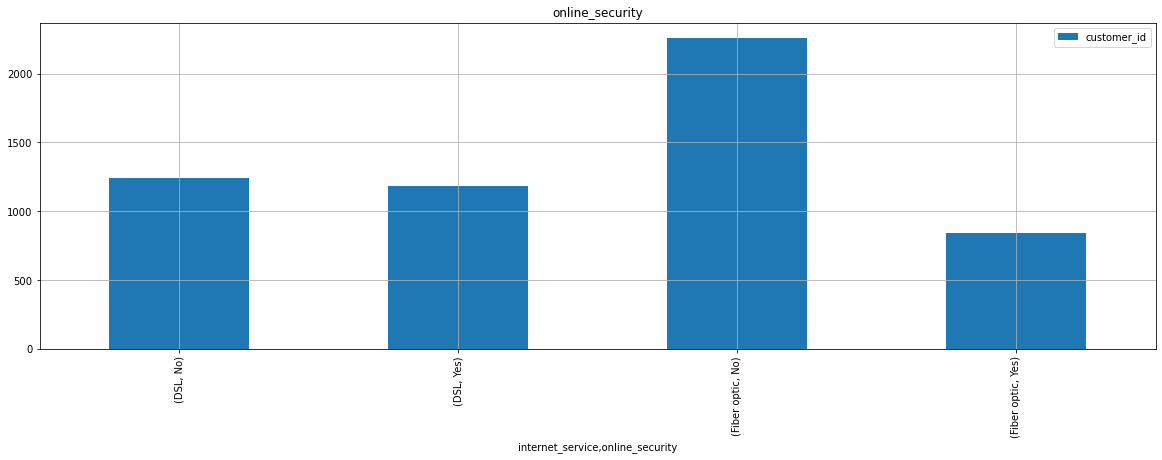

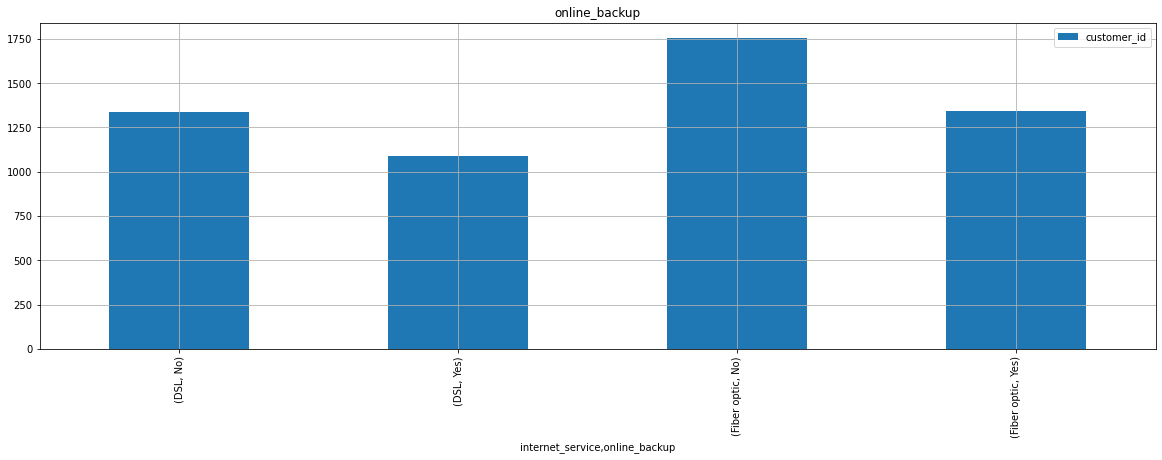

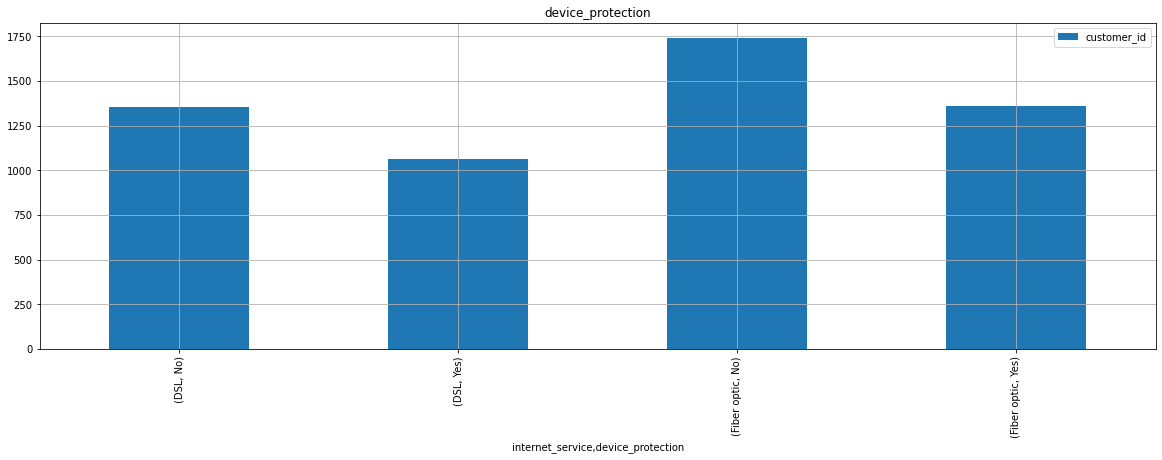

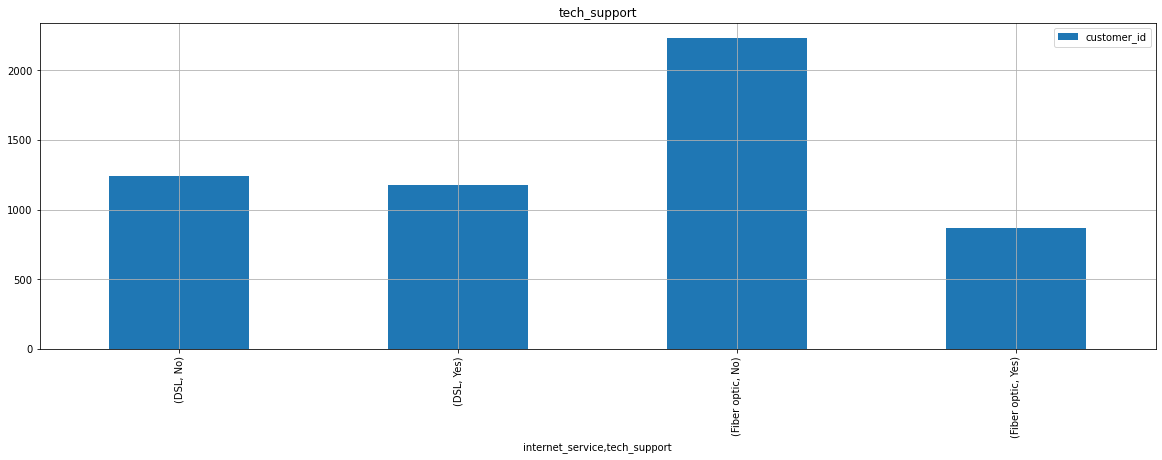

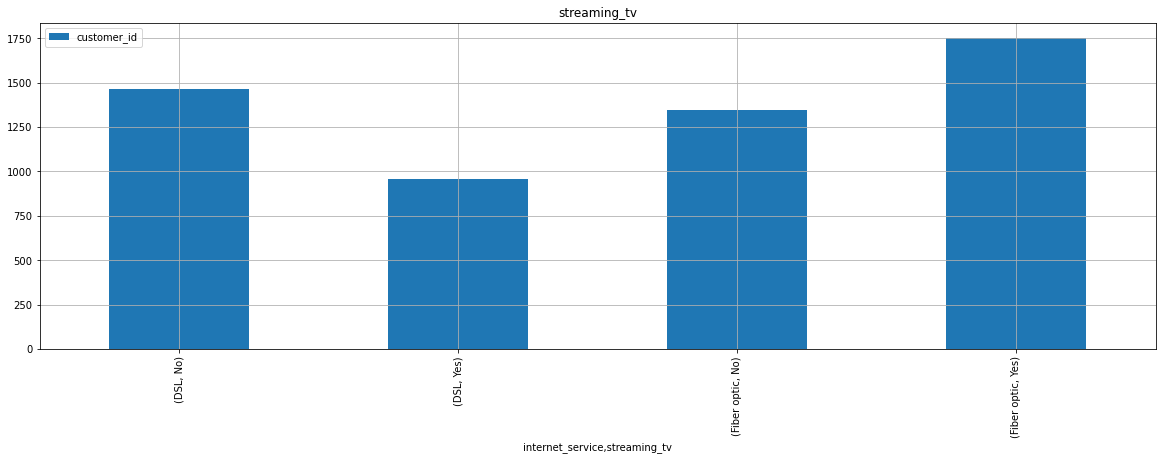

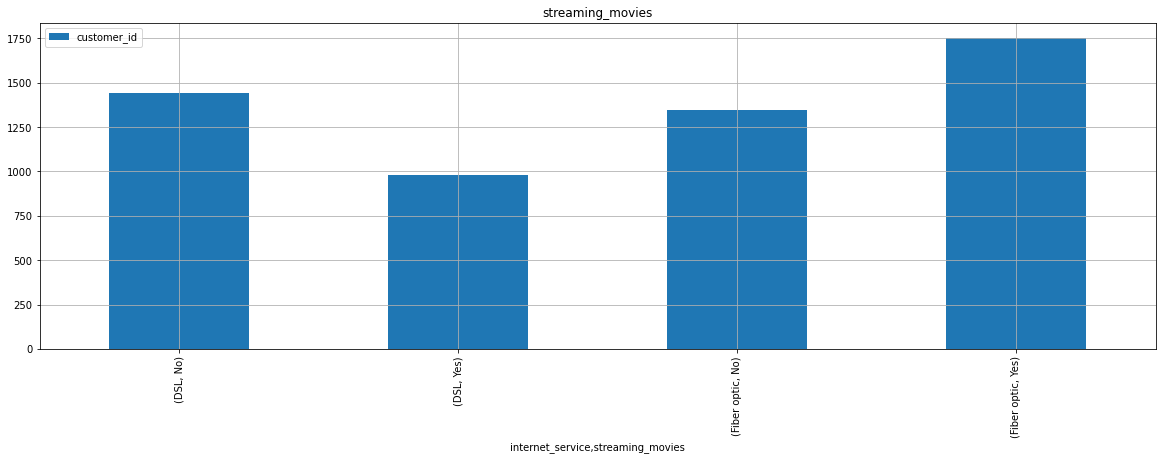

In [37]:
# Validando relación entre "internet_service" y el resto de columnas
columns = df_internet.columns
columns = columns[2:]
for i in columns:
    df_internet.groupby(['internet_service',i]).count()['customer_id'].plot(kind='bar',
                                                                        legend=True,
                                                                        figsize=(20,6),
                                                                        grid=True,
                                                                        title=i)
    plt.show()
    


Como podemos observar, de acuerdo con la agrupación, la mayoría de los servicios proporcionados son a través de `fibra óptica` pero destaca lo siguiente:

- De manera unánime los usuarios con tecnología `DSL`, la mayoría de los usuarios prefieren no hacer uso de estos servicios adicionales.
- Al tratarse de fibra óptica, los usuarios tienen el mismo comportamiento exceptuando los servicios de streaming.

Analizaremos si podemos encontrar algún patrón para `df_internet` creando un merge con la tabla `df_contract`.

In [38]:
# Aplicando un merge para "df_contract" y "df_internet"
df_contract_internet = pd.merge(df_contract,df_internet,on='customer_id',how='left')
df_contract_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   contract_ends      7043 non-null   object        
 9   internet_service   5517 non-null   object        
 10  online_security    5517 non-null   object        
 11  online_backup      5517 non-null   object        
 12  device_protection  5517 non-null   object        
 13  tech_support       5517 non-null   object        
 14  streamin

Comenzaremos buscando una relación entre aquellos clientes con montos mensuales similares haciendo uso de uno solo de los servicios adicionales que ofrece la empresa.

In [39]:
# Buscando patrones en "online_security"
df_contract_internet[(df_contract_internet['online_security'] == 'Yes') & 
                     (df_contract_internet['online_backup'] == 'No') &
                     (df_contract_internet['device_protection'] == 'No') &
                     (df_contract_internet['tech_support'] == 'No') &
                     (df_contract_internet['streaming_tv'] == 'No') &
                     (df_contract_internet['streaming_movies'] == 'No')]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_ends,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,No,DSL,Yes,No,No,No,No,No
10,9763-GRSKD,2019-01-01,No,Month-to-month,Yes,Mailed check,49.95,587.45,No,DSL,Yes,No,No,No,No,No
95,8637-XJIVR,2018-12-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,78.95,927.35,Si,Fiber optic,Yes,No,No,No,No,No
107,9750-BOOHV,2017-06-01,No,One year,No,Mailed check,30.15,927.65,No,DSL,Yes,No,No,No,No,No
116,9560-BBZXK,2017-02-01,No,Two year,No,Bank transfer (automatic),31.05,1126.35,No,DSL,Yes,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6823,7009-LGECI,2019-10-01,No,Month-to-month,Yes,Bank transfer (automatic),50.55,235.65,No,DSL,Yes,No,No,No,No,No
6891,7853-OETYL,2019-10-01,No,Month-to-month,Yes,Electronic check,29.05,129.60,No,DSL,Yes,No,No,No,No,No
6943,0032-PGELS,2019-10-01,2019-11-01 00:00:00,Month-to-month,No,Bank transfer (automatic),30.50,30.50,Si,DSL,Yes,No,No,No,No,No
6950,2075-RMJIK,2019-09-01,No,Month-to-month,Yes,Mailed check,49.40,232.55,No,DSL,Yes,No,No,No,No,No


In [40]:
# Buscando patrones en "online_backup"
df_contract_internet[(df_contract_internet['online_security'] == 'No') & 
                     (df_contract_internet['online_backup'] == 'Yes') &
                     (df_contract_internet['device_protection'] == 'No') &
                     (df_contract_internet['tech_support'] == 'No') &
                     (df_contract_internet['streaming_tv'] == 'No') &
                     (df_contract_internet['streaming_movies'] == 'No')]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_ends,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,DSL,No,Yes,No,No,No,No
27,8665-UTDHZ,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Electronic check,30.20,30.20,Si,DSL,No,Yes,No,No,No,No
40,8865-TNMNX,2019-04-01,No,One year,No,Mailed check,49.55,475.70,No,DSL,No,Yes,No,No,No,No
46,5948-UJZLF,2019-12-01,No,Month-to-month,No,Mailed check,49.25,97.00,No,DSL,No,Yes,No,No,No,No
53,7495-OOKFY,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Credit card (automatic),80.65,633.30,Si,Fiber optic,No,Yes,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6936,7693-LCKZL,2019-05-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,80.15,385.00,Si,Fiber optic,No,Yes,No,No,No,No
6977,2843-CQMEG,2018-02-01,No,Month-to-month,Yes,Mailed check,49.70,1218.25,No,DSL,No,Yes,No,No,No,No
6997,2523-EWWZL,2017-11-01,No,Month-to-month,Yes,Electronic check,76.10,2093.40,No,Fiber optic,No,Yes,No,No,No,No
7001,6304-IJFSQ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,49.90,130.10,Si,DSL,No,Yes,No,No,No,No


In [41]:
# Buscando patrones en "device_protection"
df_contract_internet[(df_contract_internet['online_security'] == 'No') & 
                     (df_contract_internet['online_backup'] == 'No') &
                     (df_contract_internet['device_protection'] == 'Yes') &
                     (df_contract_internet['tech_support'] == 'No') &
                     (df_contract_internet['streaming_tv'] == 'No') &
                     (df_contract_internet['streaming_movies'] == 'No')]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_ends,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
37,6572-ADKRS,2016-04-01,No,Month-to-month,Yes,Credit card (automatic),74.80,3548.30,No,Fiber optic,No,No,Yes,No,No,No
82,9191-MYQKX,2019-03-01,2019-10-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),75.15,496.90,Si,Fiber optic,No,No,Yes,No,No,No
126,4412-YLTKF,2017-10-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,78.05,2135.50,Si,Fiber optic,No,No,Yes,No,No,No
296,6556-DBKZF,2014-03-01,No,Two year,No,Electronic check,76.05,5436.45,No,Fiber optic,No,No,Yes,No,No,No
329,2739-CACDQ,2018-09-01,No,Month-to-month,Yes,Credit card (automatic),82.65,1470.05,No,Fiber optic,No,No,Yes,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6687,5561-NWEVX,2019-09-01,2019-11-01 00:00:00,Month-to-month,No,Electronic check,79.20,172.85,Si,Fiber optic,No,No,Yes,No,No,No
6755,9003-CPATH,2016-08-01,No,Month-to-month,No,Electronic check,79.90,3313.40,No,Fiber optic,No,No,Yes,No,No,No
6825,5022-KVDQT,2017-11-01,No,Month-to-month,Yes,Electronic check,81.30,2272.80,No,Fiber optic,No,No,Yes,No,No,No
6846,6618-RYATB,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,79.55,79.55,Si,Fiber optic,No,No,Yes,No,No,No


In [42]:
# Buscando patrones en "tech_support"
df_contract_internet[(df_contract_internet['online_security'] == 'No') & 
                     (df_contract_internet['online_backup'] == 'No') &
                     (df_contract_internet['device_protection'] == 'No') &
                     (df_contract_internet['tech_support'] == 'Yes') &
                     (df_contract_internet['streaming_tv'] == 'No') &
                     (df_contract_internet['streaming_movies'] == 'No')]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_ends,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
70,2273-QCKXA,2020-01-01,No,Month-to-month,No,Mailed check,49.05,49.05,No,DSL,No,No,No,Yes,No,No
91,2424-WVHPL,2020-01-01,No,Month-to-month,No,Electronic check,74.70,74.70,No,Fiber optic,No,No,No,Yes,No,No
132,8587-XYZSF,2014-07-01,No,Two year,No,Bank transfer (automatic),50.55,3260.10,No,DSL,No,No,No,Yes,No,No
187,8167-GJLRN,2019-11-01,No,Month-to-month,No,Electronic check,30.40,82.15,No,DSL,No,No,No,Yes,No,No
223,0742-MOABM,2019-07-01,2019-11-01 00:00:00,Month-to-month,No,Mailed check,50.05,179.35,Si,DSL,No,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6705,3733-ZEECP,2018-04-01,No,Month-to-month,Yes,Electronic check,51.10,1232.90,No,DSL,No,No,No,Yes,No,No
6734,8182-PNAGI,2019-01-01,2020-01-01 00:00:00,Month-to-month,No,Bank transfer (automatic),50.25,593.75,Si,DSL,No,No,No,Yes,No,No
6777,9572-WUKSB,2019-11-01,No,Month-to-month,Yes,Electronic check,29.90,92.25,No,DSL,No,No,No,Yes,No,No
6810,7758-XKCBS,2018-08-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,29.70,438.25,Si,DSL,No,No,No,Yes,No,No


In [43]:
# Buscando patrones en "streaming_tv"
df_contract_internet[(df_contract_internet['online_security'] == 'No') & 
                     (df_contract_internet['online_backup'] == 'No') &
                     (df_contract_internet['device_protection'] == 'No') &
                     (df_contract_internet['tech_support'] == 'No') &
                     (df_contract_internet['streaming_tv'] == 'Yes') &
                     (df_contract_internet['streaming_movies'] == 'No')]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_ends,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
47,7760-OYPDY,2019-11-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,80.65,144.15,Si,Fiber optic,No,No,No,No,Yes,No
80,5919-TMRGD,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,79.35,79.35,Si,Fiber optic,No,No,No,No,Yes,No
89,3016-KSVCP,2017-09-01,No,Month-to-month,No,Mailed check,33.75,1009.25,No,DSL,No,No,No,No,Yes,No
156,9167-APMXZ,2018-04-01,No,Month-to-month,Yes,Bank transfer (automatic),84.15,1821.95,No,Fiber optic,No,No,No,No,Yes,No
203,7018-WBJNK,2019-01-01,No,Month-to-month,Yes,Credit card (automatic),78.30,1033.95,No,Fiber optic,No,No,No,No,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6847,8930-XOTDP,2018-08-01,No,Month-to-month,No,Mailed check,55.95,1082.80,No,DSL,No,No,No,No,Yes,No
6888,3191-CSNMG,2019-11-01,No,Month-to-month,Yes,Electronic check,80.70,239.45,No,Fiber optic,No,No,No,No,Yes,No
6908,1750-CSKKM,2019-02-01,2019-11-01 00:00:00,Month-to-month,No,Electronic check,55.35,449.75,Si,DSL,No,No,No,No,Yes,No
6912,2215-ZAFGX,2019-05-01,No,Month-to-month,Yes,Electronic check,85.50,791.70,No,Fiber optic,No,No,No,No,Yes,No


In [44]:
# Buscando patrones en "streaming_movies"
df_contract_internet[(df_contract_internet['online_security'] == 'No') & 
                     (df_contract_internet['online_backup'] == 'No') &
                     (df_contract_internet['device_protection'] == 'No') &
                     (df_contract_internet['tech_support'] == 'No') &
                     (df_contract_internet['streaming_tv'] == 'No') &
                     (df_contract_internet['streaming_movies'] == 'Yes')]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_ends,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
45,3714-NTNFO,2016-01-01,No,Month-to-month,Yes,Electronic check,84.50,3906.70,No,Fiber optic,No,No,No,No,No,Yes
76,6416-JNVRK,2016-04-01,No,One year,No,Credit card (automatic),55.65,2688.85,No,DSL,No,No,No,No,No,Yes
130,2876-GZYZC,2019-01-01,No,Month-to-month,Yes,Electronic check,85.95,1215.65,No,Fiber optic,No,No,No,No,No,Yes
133,3091-FYHKI,2019-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,35.45,35.45,Si,DSL,No,No,No,No,No,Yes
155,6551-GNYDG,2018-12-01,No,Month-to-month,Yes,Bank transfer (automatic),80.90,1152.80,No,Fiber optic,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6831,9451-LPGOO,2019-04-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,86.80,620.35,Si,Fiber optic,No,No,No,No,No,Yes
6884,7384-GHBPI,2019-08-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,35.15,99.75,Si,DSL,No,No,No,No,No,Yes
6932,0463-ZSDNT,2019-04-01,No,Month-to-month,Yes,Bank transfer (automatic),56.75,503.25,No,DSL,No,No,No,No,No,Yes
6953,1564-NTYXF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,82.00,1127.20,Si,Fiber optic,No,No,No,No,No,Yes


In [45]:
# Buscando patrones sin servicios adicionales
df_contract_internet[(df_contract_internet['online_security'] == 'No') & 
                     (df_contract_internet['online_backup'] == 'No') &
                     (df_contract_internet['device_protection'] == 'No') &
                     (df_contract_internet['tech_support'] == 'No') &
                     (df_contract_internet['streaming_tv'] == 'No') &
                     (df_contract_internet['streaming_movies'] == 'No')]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_ends,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Si,Fiber optic,No,No,No,No,No,No
34,3413-BMNZE,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),45.25,45.25,No,DSL,No,No,No,No,No,No
36,6047-YHPVI,2019-06-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,69.70,316.90,Si,Fiber optic,No,No,No,No,No,No
105,6180-YBIQI,2019-09-01,No,Month-to-month,No,Mailed check,24.30,100.20,No,DSL,No,No,No,No,No,No
113,4846-WHAFZ,2016-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,76.50,2868.15,Si,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,1122-JWTJW,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,70.65,70.65,Si,Fiber optic,No,No,No,No,No,No
7026,8775-CEBBJ,2019-02-01,2019-11-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,Si,DSL,No,No,No,No,No,No
7032,6894-LFHLY,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,75.75,75.75,Si,Fiber optic,No,No,No,No,No,No
7033,9767-FFLEM,2016-12-01,No,Month-to-month,Yes,Credit card (automatic),69.50,2625.25,No,Fiber optic,No,No,No,No,No,No


Ahora verificaremos que es lo que sucede al aplicar un merge entre `df_contract` y `df_phone` con la intención de verificar si los clientes tienen más de un servicio contratado con la intención de encontrar una relación entre `monthly_charge` y. `multiple_lines`.

In [46]:
# Aplicando un merge para "df_contract" y "df_phone"
df_contract_phone = pd.merge(df_contract,df_phone,on='customer_id',how='left')
df_contract_phone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   contract_ends      7043 non-null   object        
 9   multiple_lines     6361 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 605.3+ KB


In [47]:
# Verificando si existe alguna relación
df_contract_phone[df_contract_phone['multiple_lines'] == 'No']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_ends,multiple_lines
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Si,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Si,No
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,No,No
10,9763-GRSKD,2019-01-01,No,Month-to-month,Yes,Mailed check,49.95,587.45,No,No
...,...,...,...,...,...,...,...,...,...,...
7030,0871-OPBXW,2019-12-01,No,Month-to-month,Yes,Mailed check,20.05,39.25,No,No
7033,9767-FFLEM,2016-12-01,No,Month-to-month,Yes,Credit card (automatic),69.50,2625.25,No,No
7035,8456-QDAVC,2018-07-01,No,Month-to-month,Yes,Bank transfer (automatic),78.70,1495.10,No,No
7037,2569-WGERO,2014-02-01,No,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No,No


De acuerdo con el filtrado anterior, podemos determinar que no hay una relación directa entre el cargo mensual, la tecnología utilizada, los servicios adicionales y la cantidad de contrataciones por el mismo cliente pues si bien son muy cercanas las cantidades unas quedan por encima y otras por debajo aun haciendo la multiplicación de los meses pagados por el cargo mensual `sin servicios adicionales` por lo que no podemos dar por hecho que es de esa forma.

Hasta este punto, no podemos avanzar hasta no aclarar las dudas de la sección 3 `Lista de preguntas` pues es importante comenzar a discriminar aquellos datos que no tienen relevancia para dicho análisis y por lo que podemos considerar hasta este momento es que:

- De la tabla `df_contract`, la columna `paperless_billing` no tiene relevancia alguna para el análisis pues no afecta de ninguna forma el servicio ni las tarifas.
- De la tabla `df_phone` verificar que el hecho de que se cuente con múltiples líneas significa la contratación de más de un servicio y de ser así, como podemos encontrar las tarifas reales por servicio contratado si los cargos mensuales no coinciden con el cargo total a lo largo de plazo.
- Al no conocer el costo de los servicios adicionales ni las condicionantes para determinar el costo mensual total en contraste con el cargo total, no podemos pensar en discriminar las características que nos proporciona `df_internet` por lo que podriamos considerar optar por la eliminación de aquellos clientes que no se encuentren en esta tabla y no el eliminar las características.

# Lista de preguntas:

## Contract

Al analizar la columna `end_date` nos encontramos con unicaménte 4 fechas de finalización de contrato que son anteriores a la leyenda establecida por **Interconnect** que dice:

    **La información del contrato es válida a partir del 1 de febrero de 2020.**
    
Por lo que es importante aclarar:
- **¿Todos aquellos contratos que son anteriores al 1 de febrero de 2020 deben ser omitidos de este modelo?**.
- **Aquellos contratos que aun estan vigentes, ¿qué fecha es la que tienen actualmente?**
- **¿El cargo mensual se refiere al cargo fijo que se tiene mensualmente por el servicio ofrecido?**

## Personal

- **La columna `senior_citizen` nos indica si se trata de un cliente de la tercera edad, ¿qué estado confirma esta afirmación?**

## Internet

- **¿Los servicios adicionales que ofrece la empresa tienen un cargo extra, de ser así cuál es el monto de cada uno y como es que se aplica al monto mensual?**

## General

- **Es importante conocer el periodo de vigencia de los contratos que aun permanecen en este análisis para fines de cálculos y poder recuperar la mayor cantidad de registros, esto es debido a que no podemos descartar aun ninguna característica o considerarla irrelevante para el análisis puesto que no tenemos la información completa.**
- **¿Hay información complementaria a estos archivos que pueda ser de utilidad?**

# Propuesta de solución

1. Una vez se aclaren las dudas, se deberá análisar nuevamente el `df` completo con la intención de recuperar la mayor cantidad de datos posible y descartar aquellos datos que no son funcionales.
2. A partir de lo ya encontrado podemos crear pruebas de hipótesis donde: 
    - **H0: Los usuarios que usan como método de pago la chequera electrónica, tienen en promedio el mismo cargo mensual que el resto de métodos de pago.**
    - **H0: Los usuarios con métodos de pago automáticos tienen en promedio el mismo cargo mensual que el resto.**
    - **H0: El uso de los servicios streaming de peliculas tiene en promedio la misma tasa de cargo total que el streaming de peliculas.**
3. Aplicar OneHotEncoder a las columnas con valores binarios, esto es declarado desde este punto pues por las cualidades de los datos, no es factible usar LabelEncoder pues no hay una relación jerarquica alguna.
4. Independientemente del tipo de problema que se tenga, que en este caso es un problema de clasificación, podemos hacer uso tanto de herramientas de Machine Learning como de Deep Learning por lo que se propone evaluar en ambos casos.
5. Evaluar el rendimiento de dichos modelos bajo distintas métricas que nos permitan identificar su calidad de predicción.

-----------------------------------------------------------------------------
# --------------- Parte 2 ---------------
## Preprocesamiento

Ya que las dudas fuerón aclaradas y se dan por hecho las suspociones, ademas que, no se cuenta con más datos que puedan complementar lo ya analizado, comenzaremos con el preprocesamiento de las tablas, iniciando por eliminar aquellos datos que no son de relevancia y aplicando `OHE` a las respectivas columnas que lo requieran.

In [48]:
# Visualizando "df_contract"
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_ends
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Si
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Si


Como anteriormente se menciono, para `df_contract` la columna `paperless_billing` no es funcional pues esta información simplemente se trata de algo adicional a lo referente respecto al contrato (a menos que implique un costo extra), ademas podemos añadir que si bien, no nos mencionan explicitamente la fecha hasta la que se va a realizar este análisis, sabemos por información proporcionada textual que esta fecha es `1-02-2020` por lo que consideraremos esta fecha como la **actualidad** por lo que la columna `end_date` debe ser modificada de igual forma.

Por otro lado a las columnas `type`, `payment_method` y `contract_ends` deben ser harcodeadas al tipo de dato correcto con la interpretación correcta para poder ser procesadas por los modelos de `machine learning` y `deep learning`.

## Enriqueciendo "df_contract" con los datos de las columnas "begin_date" y "end_date"

In [49]:
# Trabajando con la columna "end_date"
# Creando "change_to_datetime"
def change_to_datetime(data):
    if data == 'No':
        return '2020-02-01'
    else:
        return pd.to_datetime(data)

In [50]:
# Aplicando "change_to_datetime"
df_contract['end_date'] = df_contract['end_date'].apply(change_to_datetime)
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   contract_ends      7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 495.3+ KB


/var/folders/g2/6f4slx3d02g5s4th9bbb102m0000gn/T/ipykernel_51353/3737506203.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_contract['end_date'] = df_contract['end_date'].apply(change_to_datetime)


In [51]:
# Visualizando "df_contract"
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_ends
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Si
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Si


Debido a que es importante en el modelo la consideración de las fechas de inicio y fin de contrato (en caso de aplicar), debemos considerar la información de `df_contract` como una serie de tiempo. Al ser de este modo, podemos extraer determinadas características que favorezcan en el sentido de alimentar con datos nuestro modelo por lo que es importante analizar las siguientes preguntas:

- ¿Es posible extraer características de las columnas `begin_date` y `end_date`?. Si y estas pueden ser cantidad de días, meses y años de vigencia del contrato.
- ¿Los datos proporcionados muestran un secuencia ordenada que permita la creación de nuevas características?. Si bien el hecho de trabajar con fechas nos permite realizar un ordenamiento, estos datos dependen de dos fechas las cuales muestran evidentemente una variación aleatoria, es decir, el periodo de vigencia de los contratos es una característica única del cliente y no de las fechas.

De manera general, las preguntas anteriormente planteadas nos permiten ejecutar procesos de enriquecimiento de los datos evitando algún tipo de alteración a la información conjunta que este nos proporciona, por lo que procederemos con dicho enriquecimiento para finalizar con la eliminación de las columnas `begin_date` y `end_date` que aunque esta última es nuestra variable ojetivo, ya ha sido trabajada anteriormente resultando en `contract_ends` que nos indica si ya ha finalizado el contrato o no.

In [52]:
# Creando "days", "months" y "years"
def convert_dates(data):  
    days = (data['end_date']-data['begin_date']).days
    months = (data['end_date']-data['begin_date']) / pd.Timedelta(days=30)
    years = (data['end_date']-data['begin_date']) / pd.Timedelta(days=365)
    
    return pd.Series({'days':days,'months':months, 'years':years})

In [53]:
# Aplicando "convert_dates" y concatenando información a "df_contract"
df_contract[['days','months','years']] = df_contract.apply(convert_dates,axis=1)

In [54]:
# Eliminando "begin_date" y "end_date"
df_contract.drop(columns=['begin_date','end_date','paperless_billing'],inplace=True)
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      7043 non-null   object 
 1   type             7043 non-null   object 
 2   payment_method   7043 non-null   object 
 3   monthly_charges  7043 non-null   float64
 4   total_charges    7043 non-null   float64
 5   contract_ends    7043 non-null   object 
 6   days             7043 non-null   float64
 7   months           7043 non-null   float64
 8   years            7043 non-null   float64
dtypes: float64(5), object(4)
memory usage: 495.3+ KB


In [55]:
# Visualizando datos
df_contract.head()

,customer_id,type,payment_method,monthly_charges,total_charges,contract_ends,days,months,years
0,7590-VHVEG,Month-to-month,Electronic check,29.85,29.85,No,31.0,1.033333,0.084932
1,5575-GNVDE,One year,Mailed check,56.95,1889.50,No,1036.0,34.533333,2.838356
2,3668-QPYBK,Month-to-month,Mailed check,53.85,108.15,Si,61.0,2.033333,0.167123
3,7795-CFOCW,One year,Bank transfer (automatic),42.30,1840.75,No,1371.0,45.700000,3.756164
4,9237-HQITU,Month-to-month,Electronic check,70.70,151.65,Si,61.0,2.033333,0.167123


Ya que enriquecimos la información con estos datos, procederemos con aplicar `OneHotEncoder` al resto de columnas para poder alimentar los modelos de forma correcta.

## Aplicando "OneHotEncoder" al resto de columnas de "df_contract"

In [56]:
# Creando función para aplicar OHE
def encoding(data,column):
    encoder = OneHotEncoder(drop='first')
    result = encoder.fit_transform(data[column].to_numpy().reshape(-1,1))
    res = pd.DataFrame(data=result.toarray(),columns=encoder.categories_[0][1:])
    return res

In [57]:
# Ejecutando "encoding"
result = encoding(df_contract,'type')
result

,One year,Two year
0,0.0,0.0
1,1.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.0,0.0
...,...,...
7038,1.0,0.0
7039,1.0,0.0
7040,0.0,0.0
7041,0.0,0.0


In [58]:
# Concatenando "result" y eliminando columna harcodeada
df_contract = pd.concat([df_contract,result],axis=1)
df_contract.drop(columns=['type'],inplace=True)
df_contract.head()

,customer_id,payment_method,monthly_charges,total_charges,contract_ends,days,months,years,One year,Two year
0,7590-VHVEG,Electronic check,29.85,29.85,No,31.0,1.033333,0.084932,0.0,0.0
1,5575-GNVDE,Mailed check,56.95,1889.50,No,1036.0,34.533333,2.838356,1.0,0.0
2,3668-QPYBK,Mailed check,53.85,108.15,Si,61.0,2.033333,0.167123,0.0,0.0
3,7795-CFOCW,Bank transfer (automatic),42.30,1840.75,No,1371.0,45.700000,3.756164,1.0,0.0
4,9237-HQITU,Electronic check,70.70,151.65,Si,61.0,2.033333,0.167123,0.0,0.0


Como podemos observar, le función `encoding` funciona de forma general lo que nos permite hacer uso de ella en el resto de columnas que así lo requieran.

In [59]:
# Ejecutando "encoding" para "payment_method"
result = encoding(df_contract,'payment_method')
result

,Credit card (automatic),Electronic check,Mailed check
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
7038,0.0,0.0,1.0
7039,1.0,0.0,0.0
7040,0.0,1.0,0.0
7041,0.0,0.0,1.0


In [60]:
# Concatenando "result" y eliminando columna harcodeada
df_contract = pd.concat([df_contract,result],axis=1)
df_contract.drop(columns=['payment_method'],inplace=True)
df_contract.head()

,customer_id,monthly_charges,total_charges,contract_ends,days,months,years,One year,Two year,Credit card (automatic),Electronic check,Mailed check
0,7590-VHVEG,29.85,29.85,No,31.0,1.033333,0.084932,0.0,0.0,0.0,1.0,0.0
1,5575-GNVDE,56.95,1889.50,No,1036.0,34.533333,2.838356,1.0,0.0,0.0,0.0,1.0
2,3668-QPYBK,53.85,108.15,Si,61.0,2.033333,0.167123,0.0,0.0,0.0,0.0,1.0
3,7795-CFOCW,42.30,1840.75,No,1371.0,45.700000,3.756164,1.0,0.0,0.0,0.0,0.0
4,9237-HQITU,70.70,151.65,Si,61.0,2.033333,0.167123,0.0,0.0,0.0,1.0,0.0


In [61]:
# Ejecutando "encoding" para "contract_ends"
result = encoding(df_contract,'contract_ends')
result

,Si
0,0.0
1,0.0
2,1.0
3,0.0
4,1.0
...,...
7038,0.0
7039,0.0
7040,0.0
7041,1.0


In [62]:
# Concatenando "result" y eliminando columna harcodeada
df_contract = pd.concat([df_contract,result],axis=1)
df_contract.drop(columns=['contract_ends'],inplace=True)
df_contract.head()

,customer_id,monthly_charges,total_charges,days,months,years,One year,Two year,Credit card (automatic),Electronic check,Mailed check,Si
0,7590-VHVEG,29.85,29.85,31.0,1.033333,0.084932,0.0,0.0,0.0,1.0,0.0,0.0
1,5575-GNVDE,56.95,1889.50,1036.0,34.533333,2.838356,1.0,0.0,0.0,0.0,1.0,0.0
2,3668-QPYBK,53.85,108.15,61.0,2.033333,0.167123,0.0,0.0,0.0,0.0,1.0,1.0
3,7795-CFOCW,42.30,1840.75,1371.0,45.700000,3.756164,1.0,0.0,0.0,0.0,0.0,0.0
4,9237-HQITU,70.70,151.65,61.0,2.033333,0.167123,0.0,0.0,0.0,1.0,0.0,1.0


Esta nueva tabla llamada `df_contract` ya contiene todas las columnas que serán utilizadas para las predicciones en el formato correcto. Cabe aclarar que la columna `customer_id` aun no ha sido eliminada puesto que nos servirá en un futuro para poder aplicar un `merge` entre las distintas tablas ya presentadas una vez que estas contengan la información en el formato correcto. Por último, renombraremos las columnas.

In [63]:
# Renombrando columnas
df_contract.columns = ['customer_id','monthly_charges','total_charges','days','months','years','type_one_year',
                       'type_two_year','pay_method_credit_card','pay_method_electronic_check',
                       'pay_method_mailed_check','contract_ends']
df_contract.head()

,customer_id,monthly_charges,total_charges,days,months,years,type_one_year,type_two_year,pay_method_credit_card,pay_method_electronic_check,pay_method_mailed_check,contract_ends
0,7590-VHVEG,29.85,29.85,31.0,1.033333,0.084932,0.0,0.0,0.0,1.0,0.0,0.0
1,5575-GNVDE,56.95,1889.50,1036.0,34.533333,2.838356,1.0,0.0,0.0,0.0,1.0,0.0
2,3668-QPYBK,53.85,108.15,61.0,2.033333,0.167123,0.0,0.0,0.0,0.0,1.0,1.0
3,7795-CFOCW,42.30,1840.75,1371.0,45.700000,3.756164,1.0,0.0,0.0,0.0,0.0,0.0
4,9237-HQITU,70.70,151.65,61.0,2.033333,0.167123,0.0,0.0,0.0,1.0,0.0,1.0


Ahora trabajaremos con la tabla `df_personal`.

## Aplicando "OneHotEncoder" al resto de columnas de "df_personal"

In [64]:
# Visualizando datos
df_personal.head()

,customer_id,gender,senior_citizen,parner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Lo realizado con `df_contract` se realizo de forma manual, sin embargo para `df_personal` vamos a automatizar un poco más el procedimiento de codificación y eliminado de las columnas.

In [65]:
# Ejecutando "encoding", concatenando "result" y eliminando columna harcodeada
cols = ['gender','senior_citizen','parner','dependents']
for col in cols:
    result = encoding(df_personal,col)
    df_personal = pd.concat([df_personal,result],axis=1)
    df_personal.drop(columns=[col],inplace=True)

df_personal.head()

,customer_id,Male,1,Yes,Yes
0,7590-VHVEG,0.0,0.0,1.0,0.0
1,5575-GNVDE,1.0,0.0,0.0,0.0
2,3668-QPYBK,1.0,0.0,0.0,0.0
3,7795-CFOCW,1.0,0.0,0.0,0.0
4,9237-HQITU,0.0,0.0,0.0,0.0


In [66]:
# Renombrando columnas
df_personal.columns = ['customer_id','gender','senior_citizen','parner','dependents']
df_personal.head()

,customer_id,gender,senior_citizen,parner,dependents
0,7590-VHVEG,0.0,0.0,1.0,0.0
1,5575-GNVDE,1.0,0.0,0.0,0.0
2,3668-QPYBK,1.0,0.0,0.0,0.0
3,7795-CFOCW,1.0,0.0,0.0,0.0
4,9237-HQITU,0.0,0.0,0.0,0.0


Ahora trabajaremos con la tabla `df_internet`.

## Aplicando "OneHotEncoder" al resto de columnas de "df_internet"

In [67]:
# Visualizando datos
df_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [68]:
# Ejecutando "encoding", concatenando "result" y eliminando columna harcodeada
col_names = df_internet.columns
cols = ['internet_service','online_security','online_backup','device_protection',
        'tech_support','streaming_tv','streaming_movies']

for col in cols:
    result = encoding(df_internet,col)
    df_internet = pd.concat([df_internet,result],axis=1)
    df_internet.drop(columns=[col],inplace=True)

df_internet.columns = col_names
df_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5575-GNVDE,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,3668-QPYBK,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,9237-HQITU,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Por último trabajaremos con la tabla `df_phone`.

## Aplicando "OneHotEncoder" al resto de columnas de "df_phone"

In [69]:
# Visualizando datos
df_phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [70]:
# Ejecutando "encoding", concatenando "result" y eliminando columna harcodeada
col_names = df_phone.columns
cols = ['multiple_lines']

for col in cols:
    result = encoding(df_phone,col)
    df_phone = pd.concat([df_phone,result],axis=1)
    df_phone.drop(columns=[col],inplace=True)

df_phone.columns = col_names
df_phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,0.0
1,3668-QPYBK,0.0
2,9237-HQITU,0.0
3,9305-CDSKC,1.0
4,1452-KIOVK,1.0


Como podemos observar, ya tenemos todas las columnas en el formato correcto para ser procesadas por lo que continuaremos aplicando un `merge` a todas las columnas, esto es debido a que necesitamos que dicha mezcla se haga de forma ordenada ademas de que en todo momento deben coincidir los usuarios con sus respectivos datos.

Como anteriormente también se mencionó, debido a la limitada información que tenemos respecto a cada registro por parte de la empresa, es viable que hagamos una eliminación de aquellos registros que no se encuentren completos  (y que no pudimos recuperar debido a la falta de información) a eliminar columnas que al final podrían tener una implicación mayor entre si por lo que haremos uso de un híper parámetro especifico en la función `merge` y será `how="inner"` lo que nos permitira concatenar los registros que tengan coincidencias específicamente en la columna `customer_id` que es nuestra columna referencia en todas las tablas.

## Aplicando "merge" a todas las tablas ya preprocesadas

In [71]:
# Aplicando "merge" para construir "df"
df = pd.merge(df_contract,df_personal,on='customer_id',how='inner')
df = pd.merge(df,df_phone,on='customer_id',how='inner')
df = pd.merge(df,df_internet,on='customer_id',how='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  4835 non-null   object 
 1   monthly_charges              4835 non-null   float64
 2   total_charges                4835 non-null   float64
 3   days                         4835 non-null   float64
 4   months                       4835 non-null   float64
 5   years                        4835 non-null   float64
 6   type_one_year                4835 non-null   float64
 7   type_two_year                4835 non-null   float64
 8   pay_method_credit_card       4835 non-null   float64
 9   pay_method_electronic_check  4835 non-null   float64
 10  pay_method_mailed_check      4835 non-null   float64
 11  contract_ends                4835 non-null   float64
 12  gender                       4835 non-null   float64
 13  senior_citizen    

Como podemos observar, tuvimos una reducción considerable respecto a la cantidad de registros que se tenían inicialmente que era de `7043` paso a `4835`, es decir, cerca de un `31%` de registros fuerón eliminados y esto se debe a que la información contenida en los distintos archivos `csv` tienen información diferente pues aparentemente no contamos con los datos suficientes para poder recuperar sobre los registros faltantes que inicialmente se planteaban por lo que trabajaremos con `df` para el entrenamiento de los modelos predictivos.

El modelo primero será sometido a las pruebas de hipótesis anteriormente descritas en este documento las cuales son:
- **H0: Los usuarios que usan como método de pago la chequera electrónica, tienen en promedio el mismo cargo mensual que el resto de métodos de pago.**
- **H0: Los usuarios con métodos de pago automáticos tienen en promedio el mismo cargo mensual que el resto.**
- **H0: El uso de los servicios streaming de peliculas tiene en promedio la misma tasa de cargo total que el streaming de peliculas.**

Para esta prueba de hipótesis es importante identificar cuál es la adecuada. Tenemos 4 opciones para poder trabajar y debemos conocer que es lo que esta pasando con nuestras pruebas y saber con que datos contamos:
- `Hipótesis con dos colas`: Requerímos de un valor específico de comparación con la media de la muestra.
- `Hipótesis con una cola`: Requerimos un valor específico de comparación con la media de la muestra, en este caso nuestro `p value` se dividirá entre 2 para considerar ambas posiciones.
- `Hipótesis sobre la igualdad de las medias de dos poblaciones`: Requerimos de dos muestras y si se conoce la varianza de ambas muestras y estas son iguales puede ajustarse el parámetro `equal_var = True`, en caso contrario se coloca en `False`.
- `Hipótesis sobre la igualdad de las medias de muestras emparejadas`:  Requereimos de dos muestras con la característica de que estas provienen del mismo set de datos con una diferencia temporal.

De acuerdo con los parámetros que requiere cada una de las pruebas y por la prueba de hipótesis planteada, podemos concluir en usar `igualdad de las medias de dos poblaciones` por lo siguiente:
- Vamos a compara dos muestras que aunque provienden del mismo set de datos, estas son independientes una de otra puesto que vamos a comparar el promedio de una muestra contra el promedio de otra.
- Estas muestras no varian conforme el tiempo (para este caso en específico) puesto que vamos a hacer la evaluación del periodo completo.
- No contamos con un parámetro en específico con el que querramos trabajar para comparar con la media de la muestra.

En conclusión, trabajaremos para estos fines con `Hipótesis sobre la igualdad de las medias de dos poblaciones`.

# Pruebas de hipótesis
## H0: Los usuarios que usan como método de pago la chequera electrónica, tienen en promedio el mismo cargo mensual que el resto de métodos de pago.

In [72]:
# Extrayendo información de "df"
conjunto_a = df[(df['pay_method_electronic_check'] == 1.0)].reset_index(drop=True)
conjunto_b = df[(df['pay_method_electronic_check'] == 0.0)].reset_index(drop=True)
conjunto_a.shape, conjunto_b.shape

((2017, 24), (2818, 24))

Ajustaremos el valor α = 5% que es un valor convencional de significación estadística y ejecutaremos la prueba de hipótesis sobre la igualdad de medias de dos poblaciones.

Para poder ejecutar la prueba de hipótesis, es importante primero determinar si las muestras tienen varianzas iguales o similares mayormente, para esto, pondremos a prueba dichas muestras usando el algoritmo de Levene que se encarga de probar que todas las entradas de la hipótesis nula tienen varianzas iguales.

In [73]:
# Ejecutando la prueba de "Levene"
alpha = 0.05
stat,p = levene(conjunto_a['monthly_charges'],conjunto_b['monthly_charges'])
print("P value:", p)
if p < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

P value: 1.3895227496332234e-13
Rechazamos la hipótesis nula


Como podemos observar de acuerdo al resultado, es practicaménte nula la probabilidad de poder tener una varianza similar entre los dos conjuntos, por lo que la hipótesis nula es rechazada y por ende el híper parámetro `equal_var=False`.

In [74]:
# Ejecutando prueba de hipótesis
alpha = 0.05
results = st.ttest_ind(conjunto_a['monthly_charges'],conjunto_b['monthly_charges'],equal_var=False)
print('p-value: ', results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value:  3.1753836225291182e-09
Rechazamos la hipótesis nula


De acuerdo con la prueba estadística, podemos concluir que es prácticamente improbable obtener de una muestra aleatoria de cada conjunto el mismo cargo mensual de aquellos que prefieren usar como método de pago la `chequera eletrónica` a los que usan cualquier otro método.

## H0: Los usuarios con métodos de pago automáticos tienen en promedio el mismo cargo mensual que el resto.

In [75]:
# Extrayendo información de "df"
conjunto_a = df[(df['pay_method_credit_card'] == 1.0) | ((df['pay_method_credit_card'] == 0.0) &
                                                         (df['pay_method_electronic_check'] == 0.0) &
                                                         (df['pay_method_mailed_check'] == 0.0))].reset_index(drop=True)
conjunto_b = df[(df['pay_method_electronic_check'] == 1.0) |
                (df['pay_method_mailed_check'] == 1.0)].reset_index(drop=True)
conjunto_a.shape, conjunto_b.shape

((2106, 24), (2729, 24))

In [76]:
# Ejecutando la prueba de "Levene"
alpha = 0.05
stat,p = levene(conjunto_a['monthly_charges'],conjunto_b['monthly_charges'])
print("P value:", p)
if p < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

P value: 0.9212188515906821
No rechazamos la hipótesis nula


Como podemos observar de acuerdo al resultado, tenemos al menos un `92%` de probabilidad de poder tener una varianza similar entre los dos conjuntos, por lo que la hipótesis nula es rechazada y por ende el híper parámetro `equal_var=True`.

In [77]:
# Ejecutando prueba de hipótesis
alpha = 0.05
results = st.ttest_ind(conjunto_a['monthly_charges'],conjunto_b['monthly_charges'],equal_var=True)
print('p-value: ', results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value:  8.646165776813195e-16
Rechazamos la hipótesis nula


De acuerdo con la prueba estadística, podemos concluir que es prácticamente improbable obtener de una muestra aleatoria de cada conjunto con el mismo cargo mensual de aquellos que prefieren usar como método de pago automáticos en comparación con el resto.

## H0: El uso de los servicios streaming de peliculas tiene en promedio la misma tasa de cargo total que el streaming de peliculas.

In [78]:
# Extrayendo información de "df"
conjunto_a = df[(df['streaming_tv'] == 1.0)].reset_index(drop=True)
conjunto_b = df[(df['streaming_movies'] == 1.0)].reset_index(drop=True)
conjunto_a.shape, conjunto_b.shape

((2422, 24), (2434, 24))

In [79]:
# Ejecutando la prueba de "Levene"
alpha = 0.05
stat,p = levene(conjunto_a['total_charges'],conjunto_b['total_charges'])
print("P value:", p)
if p < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

P value: 0.8151107201576941
No rechazamos la hipótesis nula


Como podemos observar de acuerdo al resultado, tenemos al menos un `81%` de probabilidad de poder tener una varianza similar entre los dos conjuntos, por lo que la hipótesis nula es rechazada y por ende el híper parámetro `equal_var=True`.

In [80]:
# Ejecutando prueba de hipótesis
alpha = 0.05
results = st.ttest_ind(conjunto_a['total_charges'],conjunto_b['total_charges'],equal_var=True)
print('p-value: ', results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value:  0.8103379751154409
No rechazamos la hipótesis nula


De acuerdo con la prueba estadística, podemos ver que hay al menos un `81%` de obtener de manera aleatoria dos cargos totales muy similares entre aquellos que hacen uso de los servicios de `streaming_tv` y `streaming_movies`.

Una vez hemos realizado las pruebas de hipótesis, podemos comenzar con la prueba de modelos predictivos para lo que haremos uso de algunos modelos de `Machine Learning` que son:

- Regresión logística.
- Árboles de decisión.
- Bosques aleatorios.
- LightGBM.

Compararemos los resultados para ver que modelo tiene un mejor desempeño y continuaremos ahora con la implementación de un modelo de `deep learning` para lo que también mediremos su desempeño y compararemos con los anteriores.

Como métrica de evaluación principal implementaremos un algorítmo que permita medir el área bajo la curva generada por el modelo (**AUC-ROC**) y como adicional será la exactitud (**accuracy**).

# Implementación de modelos de machine learning
## Regresión logística

Primero eliminaremos la columna `customer_id` pues la única función para la que se necesitaba ya fue ejecutada posteriormente aplicaremos una escala pues hay una variación significativa entre las cantidades que se tienen en los registros y despues pasaremos a hacer la separación de conjuntos de entrenamiento y testeo que serán usados por todos los modelos predictivos.

In [81]:
# Eliminación de "customer_id"
df.drop(columns=['customer_id'],inplace=True)

In [82]:
# Separación de variables independientes y dependientes
X = df.drop(columns=['contract_ends'])
y = df['contract_ends']
X.shape, y.shape

((4835, 22), (4835,))

In [83]:
# Escalamiento de datos
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

In [84]:
# Separación de conjutos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3868, 22), (967, 22), (3868,), (967,))

In [85]:
# Implementando modelo
lr_model = LogisticRegression(random_state=12345)
lr_model.fit(X_train,y_train)
lr_predict = lr_model.predict(X_test)
lr_score = lr_model.score(X_test,y_test)

In [86]:
# Calculando AUC-ROC
auc_roc_lr = roc_auc_score(y_test,lr_predict)

Para el resto de modelos es importante que se haga una selección correcta de los híper parámetros que recibiran por lo que implementaremos un modelo llamado `GridSearchCV` que nos permite obtener los parámetros con el mejor desempeño calculado.

## Árboles de decisión

In [87]:
# Encontrando los mejores hiper parámetros
dtc = DecisionTreeClassifier(random_state=12345)
parameters = {'max_depth': range(2, 15), 
              'min_samples_split': range(2, 50,2), 
              'min_samples_leaf': range(2, 50,2),
              'criterion': ['gini', 'entropy'],
              'splitter': ['best'],
              'random_state': [12345]}
grid = GridSearchCV(dtc, parameters, cv=5, n_jobs=-1,scoring='roc_auc')
grid.fit(X_train, y_train)
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 46, 'random_state': 12345, 'splitter': 'best'}
Best score:  0.8267412530744261
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=6,
                       min_samples_split=46, random_state=12345)


In [88]:
# Implementando modelo
dtc_model = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=6,
                       min_samples_split=46, random_state=12345)
dtc_model.fit(X_train,y_train)
dtc_predict = dtc_model.predict(X_test)
dtc_score = dtc_model.score(X_test,y_test)

In [89]:
# Calculando AUC-ROC
auc_roc_dtc = roc_auc_score(y_test,dtc_predict)

## Bosques aleatorios

In [90]:
# Encontrando los mejores hiper parámetros
rfc  = RandomForestClassifier(random_state=12345)
parameters = {'max_depth': range(2,6),
              'min_samples_split': range(2,16,2),
              'min_samples_leaf': range(2,16,2),
              'criterion': ['gini','entropy']}
grid = GridSearchCV(rfc, parameters, cv=5, n_jobs=-1,scoring='roc_auc')
grid.fit(X_train, y_train)
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 12}
Best score:  0.8343008674418666
Best estimator:  RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=12,
                       random_state=12345)


In [91]:
# Implementado modelo
rfc_model = RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=12,random_state=12345)
rfc_model.fit(X_train,y_train)
rfc_predict = rfc_model.predict(X_test)
rfc_score = rfc_model.score(X_test,y_test)

In [92]:
# Calculando AUC-ROC
auc_roc_rfc = roc_auc_score(y_test,rfc_predict)

## Potenciación de graciente LightGBM

In [93]:
# "LightGBM" para datos numéricos
train_data = lgb.Dataset(X_train,label=y_train)
test_data = lgb.Dataset(X_test,label=y_test)

params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': 'auc',
          'num_leaves': 31,
          'learning_rate': 0.05}

gbm_model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data])
gbm_predict = gbm_model.predict(X_test, num_iteration=gbm_model.best_iteration)
gbm_predict = pd.Series([1 if i > 0.5 else 0 for i in gbm_predict])
gbm_score = accuracy_score(y_test,gbm_predict)

[LightGBM] [Info] Number of positive: 1258, number of negative: 2610
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 967
[LightGBM] [Info] Number of data points in the train set: 3868, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325233 -> initscore=-0.729827
[LightGBM] [Info] Start training from score -0.729827
[1]	valid_0's auc: 0.834216
[2]	valid_0's auc: 0.83189
[3]	valid_0's auc: 0.842453
[4]	valid_0's auc: 0.840664
[5]	valid_0's auc: 0.842558
[6]	valid_0's auc: 0.846616
[7]	valid_0's auc: 0.849882
[8]	valid_0's auc: 0.849541
[9]	valid_0's auc: 0.850316
[10]	valid_0's auc: 0.851435
[11]	valid_0's auc: 0.852385
[12]	valid_0's auc: 0.852983
[13]	valid_0's auc: 0.853551
[14]	valid_0's auc: 0.854749
[15]	valid_0's auc: 0.856488
[16]	valid_0's auc: 0.856338
[17]	valid_0's auc: 0.857511
[18]	valid_0's auc: 0.85

[371]	valid_0's auc: 0.893157
[372]	valid_0's auc: 0.893214
[373]	valid_0's auc: 0.893028
[374]	valid_0's auc: 0.893099
[375]	valid_0's auc: 0.893066
[376]	valid_0's auc: 0.892985
[377]	valid_0's auc: 0.892952
[378]	valid_0's auc: 0.89289
[379]	valid_0's auc: 0.892837
[380]	valid_0's auc: 0.892994
[381]	valid_0's auc: 0.893009
[382]	valid_0's auc: 0.892875
[383]	valid_0's auc: 0.892952
[384]	valid_0's auc: 0.892866
[385]	valid_0's auc: 0.892932
[386]	valid_0's auc: 0.892827
[387]	valid_0's auc: 0.892742
[388]	valid_0's auc: 0.892789
[389]	valid_0's auc: 0.89277
[390]	valid_0's auc: 0.892689
[391]	valid_0's auc: 0.892894
[392]	valid_0's auc: 0.892761
[393]	valid_0's auc: 0.892756
[394]	valid_0's auc: 0.892813
[395]	valid_0's auc: 0.892952
[396]	valid_0's auc: 0.893128
[397]	valid_0's auc: 0.893052
[398]	valid_0's auc: 0.89299
[399]	valid_0's auc: 0.893028
[400]	valid_0's auc: 0.892999
[401]	valid_0's auc: 0.892899
[402]	valid_0's auc: 0.892885
[403]	valid_0's auc: 0.892775
[404]	valid_0

[795]	valid_0's auc: 0.891229
[796]	valid_0's auc: 0.891272
[797]	valid_0's auc: 0.891215
[798]	valid_0's auc: 0.891115
[799]	valid_0's auc: 0.891124
[800]	valid_0's auc: 0.891129
[801]	valid_0's auc: 0.891105
[802]	valid_0's auc: 0.891153
[803]	valid_0's auc: 0.891401
[804]	valid_0's auc: 0.891387
[805]	valid_0's auc: 0.891382
[806]	valid_0's auc: 0.891325
[807]	valid_0's auc: 0.891492
[808]	valid_0's auc: 0.891515
[809]	valid_0's auc: 0.891363
[810]	valid_0's auc: 0.891296
[811]	valid_0's auc: 0.891267
[812]	valid_0's auc: 0.891215
[813]	valid_0's auc: 0.891134
[814]	valid_0's auc: 0.891057
[815]	valid_0's auc: 0.891072
[816]	valid_0's auc: 0.891291
[817]	valid_0's auc: 0.891277
[818]	valid_0's auc: 0.891535
[819]	valid_0's auc: 0.891573
[820]	valid_0's auc: 0.891472
[821]	valid_0's auc: 0.891506
[822]	valid_0's auc: 0.891358
[823]	valid_0's auc: 0.891258
[824]	valid_0's auc: 0.891201
[825]	valid_0's auc: 0.891196
[826]	valid_0's auc: 0.891205
[827]	valid_0's auc: 0.891253
[828]	vali

In [94]:
# Calculando AUC-ROC
auc_roc_gbm = roc_auc_score(y_test,gbm_predict)

In [95]:
# Creando "models_metrics"
models_metrics = pd.DataFrame(data={'Accuracy':[lr_score,dtc_score,rfc_score,gbm_score],
                                    'AUC-ROC': [auc_roc_lr,auc_roc_dtc,auc_roc_rfc,auc_roc_gbm]},
                             index=['Logistic Regresion','Decision Tree','Random Forest','LightGBM'])
models_metrics

,Accuracy,AUC-ROC
Logistic Regresion,0.771458,0.724689
Decision Tree,0.770424,0.717971
Random Forest,0.781799,0.717675
LightGBM,0.814891,0.779068


Como podemos observar aunque tenemos un desempeño relativamente alto para el caso del modelo `LightGBM` por lo que podemos intentar aumentar la cantidad de registros haciendo uso de una técnica de **sobremuestreo** lo que nos permite reforzar el entrenamiento de los modelos anteriores.

### Aplicando "sobremuestreo"

In [96]:
# Creando la función "upsample"
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

Para poder aplicar la función `upsample` debemos recordar que esta ha sido cambiada de tipo de dato al ser escalada por el método `MinMaxScaler` por lo que para que funcione, debemos revertir este paso y aplicarlo únicamente a `X_train`.

In [97]:
# Aplicando "upsample"
X = df.drop(columns=['contract_ends'])
X_train = pd.DataFrame(X_train,columns=X.columns)
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
features_upsampled, target_upsampled = upsample(X_train, y_train, 5)

Una vez aplicamos el **sobremuestreo** para enriquecer los datos, nuevamente ejecutaremos `LightGBM` que fue el modelo con mejor desempeño hasta el momento.

In [98]:
# Escalamiento de datos
features_upsampled = scaler.fit_transform(features_upsampled)

In [99]:
# "LightGBM" para datos numéricos
train_data = lgb.Dataset(features_upsampled,label=target_upsampled)
test_data = lgb.Dataset(X_test,label=y_test)

params = {'boosting_type': 'dart',
          'objective': 'binary',
          'metric': 'auc',
          'num_leaves': 31,
          'learning_rate': 0.05}

gbm_model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data])
gbm_predict = gbm_model.predict(X_test, num_iteration=gbm_model.best_iteration)
gbm_predict = pd.Series([1 if i > 0.5 else 0 for i in gbm_predict])
gbm_score = accuracy_score(y_test,gbm_predict)

[LightGBM] [Info] Number of positive: 6290, number of negative: 2610
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1012
[LightGBM] [Info] Number of data points in the train set: 8900, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.706742 -> initscore=0.879611
[LightGBM] [Info] Start training from score 0.879611
[1]	valid_0's auc: 0.842115
[2]	valid_0's auc: 0.843606
[3]	valid_0's auc: 0.842484
[4]	valid_0's auc: 0.847897
[5]	valid_0's auc: 0.850443
[6]	valid_0's auc: 0.851807
[7]	valid_0's auc: 0.852179
[8]	valid_0's auc: 0.853441
[9]	valid_0's auc: 0.856299
[10]	valid_0's auc: 0.856302
[11]	valid_0's auc: 0.857812
[12]	valid_0's auc: 0.856977
[13]	valid_0's auc: 0.857704
[14]	valid_0's auc: 0.858132
[15]	valid_0's auc: 0.858384
[16]	valid_0's auc

[283]	valid_0's auc: 0.894369
[284]	valid_0's auc: 0.894192
[285]	valid_0's auc: 0.894655
[286]	valid_0's auc: 0.894316
[287]	valid_0's auc: 0.894402
[288]	valid_0's auc: 0.894349
[289]	valid_0's auc: 0.894278
[290]	valid_0's auc: 0.895304
[291]	valid_0's auc: 0.894827
[292]	valid_0's auc: 0.894803
[293]	valid_0's auc: 0.89476
[294]	valid_0's auc: 0.894521
[295]	valid_0's auc: 0.89455
[296]	valid_0's auc: 0.894402
[297]	valid_0's auc: 0.895194
[298]	valid_0's auc: 0.895161
[299]	valid_0's auc: 0.895652
[300]	valid_0's auc: 0.895662
[301]	valid_0's auc: 0.895681
[302]	valid_0's auc: 0.895471
[303]	valid_0's auc: 0.895447
[304]	valid_0's auc: 0.895399
[305]	valid_0's auc: 0.895347
[306]	valid_0's auc: 0.895204
[307]	valid_0's auc: 0.89528
[308]	valid_0's auc: 0.895533
[309]	valid_0's auc: 0.895495
[310]	valid_0's auc: 0.895428
[311]	valid_0's auc: 0.895142
[312]	valid_0's auc: 0.895256
[313]	valid_0's auc: 0.895418
[314]	valid_0's auc: 0.895418
[315]	valid_0's auc: 0.895447
[316]	valid_0

[562]	valid_0's auc: 0.909381
[563]	valid_0's auc: 0.909329
[564]	valid_0's auc: 0.909271
[565]	valid_0's auc: 0.909815
[566]	valid_0's auc: 0.909753
[567]	valid_0's auc: 0.909643
[568]	valid_0's auc: 0.909634
[569]	valid_0's auc: 0.909648
[570]	valid_0's auc: 0.909715
[571]	valid_0's auc: 0.909863
[572]	valid_0's auc: 0.910206
[573]	valid_0's auc: 0.910173
[574]	valid_0's auc: 0.910211
[575]	valid_0's auc: 0.910135
[576]	valid_0's auc: 0.910097
[577]	valid_0's auc: 0.910087
[578]	valid_0's auc: 0.910125
[579]	valid_0's auc: 0.910125
[580]	valid_0's auc: 0.910149
[581]	valid_0's auc: 0.910121
[582]	valid_0's auc: 0.910106
[583]	valid_0's auc: 0.910164
[584]	valid_0's auc: 0.910192
[585]	valid_0's auc: 0.910359
[586]	valid_0's auc: 0.910369
[587]	valid_0's auc: 0.910311
[588]	valid_0's auc: 0.91034
[589]	valid_0's auc: 0.910302
[590]	valid_0's auc: 0.910297
[591]	valid_0's auc: 0.910302
[592]	valid_0's auc: 0.910307
[593]	valid_0's auc: 0.910235
[594]	valid_0's auc: 0.910173
[595]	valid

[844]	valid_0's auc: 0.912907
[845]	valid_0's auc: 0.912926
[846]	valid_0's auc: 0.912926
[847]	valid_0's auc: 0.913103
[848]	valid_0's auc: 0.913079
[849]	valid_0's auc: 0.913064
[850]	valid_0's auc: 0.913241
[851]	valid_0's auc: 0.913227
[852]	valid_0's auc: 0.91336
[853]	valid_0's auc: 0.913041
[854]	valid_0's auc: 0.913045
[855]	valid_0's auc: 0.913107
[856]	valid_0's auc: 0.913475
[857]	valid_0's auc: 0.913446
[858]	valid_0's auc: 0.91347
[859]	valid_0's auc: 0.91346
[860]	valid_0's auc: 0.91358
[861]	valid_0's auc: 0.913441
[862]	valid_0's auc: 0.913332
[863]	valid_0's auc: 0.913365
[864]	valid_0's auc: 0.913341
[865]	valid_0's auc: 0.91316
[866]	valid_0's auc: 0.913308
[867]	valid_0's auc: 0.913375
[868]	valid_0's auc: 0.913398
[869]	valid_0's auc: 0.913594
[870]	valid_0's auc: 0.913542
[871]	valid_0's auc: 0.913532
[872]	valid_0's auc: 0.913775
[873]	valid_0's auc: 0.913775
[874]	valid_0's auc: 0.913775
[875]	valid_0's auc: 0.913804
[876]	valid_0's auc: 0.913718
[877]	valid_0's

In [100]:
# Calculando AUC-ROC
probas = gbm_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas)
auc_roc_gbm = auc(fpr, tpr)

De acuerdo con la tabla, podemos observar que aun aplicando el `upsample`, el desempeño no mejoro en lo absoluto, por esta razón comenzaremos a trabajar con el modelo de `deep learning` y evaluar su desempeño ante este set de datos.

# Implementación del modelo de deep learning

In [101]:
import tensorflow as tf

# Definir la arquitectura de la red neuronal
fnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
fnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
fnn_predict = fnn_model.predict(X_test)
loss, fnn_score = fnn_model.evaluate(X_test, y_test)
auc_roc_fnn = roc_auc_score(y_test, fnn_predict)

Epoch 1/100


2023-06-07 22:25:12.556706: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


121/121 [==============================] - 1s 2ms/step - loss: 0.5223 - accuracy: 0.7254 - val_loss: 0.4844 - val_accuracy: 0.7539
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.4884 - accuracy: 0.7596 - val_loss: 0.4765 - val_accuracy: 0.7622
Epoch 3/100
121/121 [==============================] - 0s 1ms/step - loss: 0.4841 - accuracy: 0.7567 - val_loss: 0.4806 - val_accuracy: 0.7642
Epoch 4/100
121/121 [==============================] - 0s 1ms/step - loss: 0.4773 - accuracy: 0.7660 - val_loss: 0.4800 - val_accuracy: 0.7570
Epoch 5/100
121/121 [==============================] - 0s 1ms/step - loss: 0.4757 - accuracy: 0.7634 - val_loss: 0.4757 - val_accuracy: 0.7642
Epoch 6/100
121/121 [==============================] - 0s 1ms/step - loss: 0.4667 - accuracy: 0.7704 - val_loss: 0.4873 - val_accuracy: 0.7456
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.4661 - accuracy: 0.7720 - val_loss: 0.4862 - val_accuracy: 0.7642
Epoch 8/100

121/121 [==============================] - 0s 1ms/step - loss: 0.1936 - accuracy: 0.9093 - val_loss: 1.0989 - val_accuracy: 0.6815
Epoch 59/100
121/121 [==============================] - 0s 1ms/step - loss: 0.1994 - accuracy: 0.9111 - val_loss: 1.1402 - val_accuracy: 0.7063
Epoch 60/100
121/121 [==============================] - 0s 1ms/step - loss: 0.1960 - accuracy: 0.9103 - val_loss: 1.2012 - val_accuracy: 0.7146
Epoch 61/100
121/121 [==============================] - 0s 1ms/step - loss: 0.1977 - accuracy: 0.9093 - val_loss: 1.1637 - val_accuracy: 0.7063
Epoch 62/100
121/121 [==============================] - 0s 1ms/step - loss: 0.1877 - accuracy: 0.9142 - val_loss: 1.2291 - val_accuracy: 0.7177
Epoch 63/100
121/121 [==============================] - 0s 1ms/step - loss: 0.2005 - accuracy: 0.8997 - val_loss: 1.1744 - val_accuracy: 0.7073
Epoch 64/100
121/121 [==============================] - 0s 1ms/step - loss: 0.1800 - accuracy: 0.9149 - val_loss: 1.2110 - val_accuracy: 0.7115
Epoch

In [102]:
# Creando "models_metrics"
models_metrics = pd.DataFrame(data={'Accuracy':[lr_score,dtc_score,rfc_score,gbm_score,fnn_score],
                                    'AUC-ROC': [auc_roc_lr,auc_roc_dtc,auc_roc_rfc,auc_roc_gbm,auc_roc_fnn]},
                             index=['Logistic Regresion','Decision Tree','Random Forest','LightGBM','F-NN'])
models_metrics

,Accuracy,AUC-ROC
Logistic Regresion,0.771458,0.724689
Decision Tree,0.770424,0.717971
Random Forest,0.781799,0.717675
LightGBM,0.813857,0.913260
F-NN,0.697001,0.719422


Una vez tenemos la tabla con el desempeño de los modelos, nos enfocaremos en aquel en el que el área bajo la curva (**AUC-ROC**) tenga mejor desempeño, esto es debido a que podemos observar que la tasa de acertividad es de al menos un `91.3%` lo que nos indica un buen desempeño del modelo, es capaz de predecir con una precisión aceptable.

Para poder visualizarlo mejor, haremos uso de una gráfica en la que se muestre su desempeño.

# AUC-ROC del modelo con el mejor desempeño

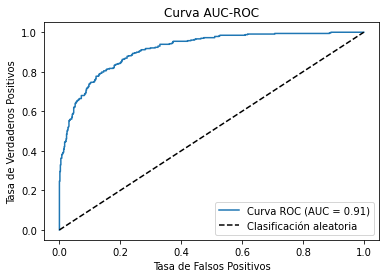

In [103]:
# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc_roc_gbm))
plt.plot([0, 1], [0, 1], 'k--', label='Clasificación aleatoria')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC')
plt.legend(loc='lower right')
plt.show()

# Conclusiones

Como podemos observar, al hacer uso del modelo de Machine Learning con gradiente descendiente potenciado (**LightGBM**), obtenemos un rendimiento considerablemente alto como podemos observar en la gráfica de la curva **AUC-ROC** en donde se compara el grado de desempeño de un modelo aleatorio que es la linea punteada recta y **LightGBM** que es la curva de color azul, como podemos observar y por definición de dicha curva, la cantidad de aciertos que se concentra por debajo de ella es de alrededor del `91%` lo que nos indica que tiene un grado de confiabilidad bastante alto, sin embargo esto no solo se debe al proceso que hace por detras el modelo, si no también al análisis de los datos proporcionados, que para resumir consto de los siguiente:

1. Visualización y análisis de cada archivo `CSV` por separado, implicando que estos debierón ser ajustados al tipo de dato correcto.
2. Preprocesamiento de los datos en los que se aplicaron criterios de reetiquetado con el fin de codificar cada columna de acuerdo a la cantidad de clases con las que cuenta, ademas también se ajusto la escala de los datos para que estos quedaran con valores de entre `0` y `1`.
3. Ajustar el equilibrio de las muestras pues de acuerdo con la información aproximadamente habia `1/3` de los registros eran para clientes que han finalizado contrato mientras que el restante es para los que no por lo que fue necesario enriquecer los datos a través de una técnica conocida como `upsample` que permite equilibrar la cantidad de registros por clase.
4. Implementar y evaluar diferentes modelos de Machine Learning y Deep Learning haciendo variar su híper parámetros dentro de un rago (hasta lo más posible considerando que la ejecución fue de manera local y los recursos de la computadora son limitados) para finalizar con la selección del modelo con mejor desempeño.

Al realizar este tipo de proyectos es importante tener claro todos y cada uno de los parámetros que la información nos proporciona, como impactan en la información misma y a que condiciones o reglas esta sometida, esto con la finalidad de contemplar todos los requerimientos necesarios para un análisis preciso y de calidad pues más allá de la aplicación de los modelos de IA, la parte fina de cualquier trabajo de este tipo es el alimentarlos con datos de calidad y perfectamente bien estudiados para que el desempeño de los modelos sea congruente y lo mejor posible.

# --------------- Parte 3 ---------------

# Informe de solución

## ¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?

Al momento de definir los pasos a seguir para este proyecto estos fuerón descritos de manera muy general pues dependián mucho de las respuestas a las preguntas inicialmente planteadas, y una de ellas en la cuál se preguntaba si hacía falta algun conjunto de datos o más reglas, su respuesta fue negativa, por lo que no implico un análisis a mayor profundidad ejecutando la propuesta de solución de manera transparente.

## ¿Qué dificultades encontraste y cómo lograste resolverlas?

Todas las dificultades se encontrarón al momento de modelar los algoritmos predictivos pues estos tenían una métrica muy baja la cuál no cumpliría con los requisitos del proyecto y esto se debió a que, aunque fue planteado en el análisis, no fue implementado de inicio en los modelos **balance de clases**, lo que detonaba una precición deficiente pero una vez se leyo detenidamente lo realizado en la parte 1 del proyecto, se implemento dicha funcionalidad logrando una precisión considerablemente más alta.

Ademas de eso, el tiempo de procesamiento de los modelos fue algo elevado pues se trabajo este proyecto de manera local en la computadora personal por lo que el cambiar valores el momento de efectuar `GridSearchCV` implicaba una mayor cantidad de tiempo de ejecución. Este apartado no pudo ser resuelto pues estaba condicionado a las características de hardware de mi máquina.

## ¿Cuáles fueron algunos de los pasos clave para resolver la tarea?

1. Un análisis adecuado y lo más completo posible de los registros proporcionados desde los archivos `CSV`.
2. El transformar los datos proporcionados en datos útiles para los modelos predictivos.
3. Hacer uso de la técnica de **upsample** pues el desbalance de clases en definitiva tuvo repercusiones graves en los desempeños de todos los modelos.
4. Implementar la mayor cantidad de modelos predictivos posibles para tener un abanico lo más amplio posible y poder escoger el mejor modelo.
5. **Todos los sprints anteriores puesto que nos proporcionarón la teoría suficiente como para poder lograr cumplir con los requisitos de evaluación de este modelo**.
6. **Las asesorias y tiempo dedicado por los tutores Francisco y Alfonso, pues sin ellos en definitiva muchos conceptos dificiles de comprender no hubieran sido posible ser aplicados de forma correcta**.

## ¿Cuál es tu modelo final y qué nivel de calidad tiene?

El modelo final que se selecciono fue **LightGBM** pues arrojo las mejores métricas de evaluación de alrededor del **0.91** gracias a que aplica el proceso de **potenciación de gradiente descendiente** lo que permite evitar lo más posible un sobreentranmiento.